# Soccer Match Betting

By: Titilayo(Teetee) Amuwo

<img src="Images/Soccer-Betting-.jpeg" width="1250" height="300">

## Overview

This notebook contains my approach to building a predictive model with the aim to minimize risk while maximizing the return on investment on soccer betting. Building a predictive model for Soccer betting is a daunting task due to many studies all over the world trying to beat the bookmakers. However, the factors contributing to betting odds are not fully traceable and in contrast to rating-based forecasts, no straightforward measure of team specific quality is deducible from the betting odds. My methodology combine different Machine Learning algorithms with different odds to build a forecasting soccer model that predict the winner of a game base on the Soccer Power Index, past performance and the odds. After several tuning,I came up with a model that can achieve higher accuracy comparing to other studies with the same purpose. I also concentrated on the best performance metrics while also minimizing the loss function.

## Business Problem

Forecasting sports events like matches or tournaments has attracted the interest of different communities all over the world for quite a long time and sport events like soccer matches take place regularly, which generate huge public attention. winning soccer matches is becoming an essential aspect of soccer clubs and soccer fans. Also, The global sport gambling system is multi trillion dollar rich while there are billions of soccer fans that gamble everyday without yielding a return. My aim is to educate these set of people to make a better decision using my model to predict the soccer game before making a bet with that,they can minimize loss and yield high return. 

## Previous Research on Soccer

Different Reseachers and Data Analyst have look into The betting odds of soccer using different algorithms to forecast soccer results. ["Fabian Wunderlich" and "Daniel Memmert" used the ELO Rating Mathematical system(used in chess game) with a probit regression approach to analyze ten season in four Leagues.They emphasize that rating methods and developing more models can help to gain insights to the underlying processes in soccer sports due to the minimal goals in the game.](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0198668). I also looked at [Machine Learning Models Reveal Key Performance Metrics of Football Players to win matches](https://ieeexplore.ieee.org/document/9261335), by Jassim Almulla and Tanvir Alam. They focused on the players metric using the player performance at each stadium. That said, I decided to focus on seven leagues in six seasons in order to improve the betting odd of soccer games. 



## StakeHolder:

- Soccer Analyst and Soccer Fans

## Aim of Business Problem:

- My aim is to develop an accurate model that predicts a soccer game using the Soccer Power Index.

## Context:

- False Negative: In this context predict that a soccer team will not win or draw a match when actually they win or draw.
    
- False Postive: In this context predict that a soccer team will win or draw a match when actually they will not win or draw.

## Evaluation:

- the metrics I will be looking at are:
    
    - ** Accuracy
    - ** logloss
    - ** Precision
    - ** Recall
    - ** f1 score

## Data Understanding

The dataset was obtained  from https://projects.fivethirtyeight.com/soccer-predictions/ , and the soccer archive odds was downloaded from https://www.kaggle.com/sashchernuh/european-football. 
- The first dataset is organized into four folders with a total of 66542rows and 27columns.
    - spi global rankings intl
    - spi global rankings
    - spi matches latest
    - spi matches    
- The second dataset is organized into one folder with a total of 12674rows and 13columns.
    - Football data 

- After cleaning and merging the two dataset I end up with a 24750rows and 27columns.
     - [Data cleaning notebook can be found in the notebook folder.](https://github.com/Teetee-lab/SoccerMatchBetting/blob/main/Notebooks/DataCleaning.ipynb)
        - Data cleaning process;
          * remove unused leagues from each data csv file.
          * change the date to python datetime.
          * split the season date, in order to use just the year. 
          * drop the season column, and create a new one.
          * fill nan with zeros for the bet365 column, which I end up dropping due to less values.
          * drop nan for the scores to avoid bias information.
          
- Create the target from the home and away scores, with that I have a multiclass category (Draw/HomeWin/AwayWin).

## Import necessary liabries

In [155]:
#import necessary liabries
import numpy as np
from numpy import array
from numpy import array
from numpy import argmax
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import plotly.express as px
import itertools
import math
import time
import pickle

from matplotlib.legend_handler import HandlerBase
sns.set(style='whitegrid',font_scale=1.5)
%matplotlib inline


import statsmodels.formula.api as sm
import xgboost as xgb
from scipy import stats
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report,accuracy_score,recall_score,precision_score,f1_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectFromModel
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.classifier import ROCAUC

import warnings
warnings.filterwarnings('ignore')

Define a function that will assist with creating the target from the scores.

In [ ]:
def make_target(df):
    """
    input: the dataframe(df)
    0=draw
    1=team1(home)- win
    2=team2(Away)- win
    """
    if df['score1'] == df['score2']:
        return 0
    elif df['score1'] > df['score2']:
        return 1
    elif df['score1'] < df['score2']:
        return 2
    else:
        return 'none'

let's bring in a function that will assist with evaluating the models.

In [2]:
#define a function to evaluate the algorithms
#define a function to evaluate the algorithms
def evaluate_model(estimator,X_train,X_test,y_train,y_test):
    """
    An evaluation function that shows the classification report 
    and log_loss for the training and the test scores.
    input: 
    Algorithm - the model best output estimator
    X_train - the training features, either scaled or unscaled
    X_test - the testing features
    y_train- the training target variable
    y_test - the testing target variable

    """

    #predictions
    train_pred = estimator.predict(X_train)
    test_pred  = estimator.predict(X_test)
    
    #Roc_auc
    train_prob = estimator.predict_proba(X_train)
    test_prob = estimator.predict_proba(X_test)
    
    #print the Training scores
    print("Training Scores:")    
    print(f"Accuracy Score: {accuracy_score(y_train,train_pred)}")
    print("----")
    print(f"Log loss Score: {log_loss(y_train, train_prob)}")
    print("----")
    print(classification_report(y_train,train_pred))
    
    
    print("------------")

    
    #print Test scores  
    print("Test Scores:") 
    print(f"Accuracy Score: {accuracy_score(y_test,test_pred)}")
    print("----")
    print(f"Log loss Score: {log_loss(y_test,test_prob)}")
    print("----")
    print(classification_report(y_test,test_pred))

    
    #plot Confusion matrix
    plt.figure(figsize=(14,12))
    plt.subplot(221)
    ax=sns.heatmap(confusion_matrix(y_test,test_pred,normalize='true'),
                   annot=True,linecolor='k',linewidth=2,
                   cmap =sns.color_palette('Blues'))
    ax.xaxis.set_ticklabels(['Draw','HomeWin','AwayWin'],fontsize=15)
    ax.yaxis.set_ticklabels(['Draw','HomeWin','AwayWin'],fontsize=15)
    plt.title("Confusion Matrix",fontsize=22)
    plt.xlabel("predicted Value")
    plt.ylabel("Actual Value")  

In [3]:
soccer_data = pd.read_csv("Data/soccer-spi/soccer_matches_df.csv",index_col=0)
club_data = pd.read_csv("Data/soccer-spi/spi_data_df.csv",index_col=0)

In [4]:
soccer_data.head()

,season,date,league_id,league,team1,team2,spi1,spi2,prob1,prob2,...,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2,results,B365_Home,B365_Draw,B365A_way
0,2016,2016-08-12,1843.0,French Ligue 1,Bastia,Paris Saint-Germain,51.16,85.68,0.0463,0.8380,...,0.97,0.63,0.43,0.45,0.00,1.05,NaN,NaN,NaN,NaN
1,2016,2016-08-12,1843.0,French Ligue 1,AS Monaco,Guingamp,68.85,56.48,0.5714,0.1669,...,2.45,0.77,1.75,0.42,2.10,2.10,NaN,NaN,NaN,NaN
2,2016,2016-08-13,2411.0,Barclays Premier League,Hull City,Leicester City,53.57,66.81,0.3459,0.3621,...,0.85,2.77,0.17,1.25,2.10,1.05,NaN,NaN,NaN,NaN
3,2016,2016-08-13,2411.0,Barclays Premier League,Everton,Tottenham Hotspur,68.02,73.25,0.3910,0.3401,...,0.73,1.11,0.88,1.81,1.05,1.05,NaN,NaN,NaN,NaN
4,2016,2016-08-13,2411.0,Barclays Premier League,Crystal Palace,West Bromwich Albion,55.19,58.66,0.4214,0.2939,...,1.11,0.68,0.84,1.60,0.00,1.05,NaN,NaN,NaN,NaN


In [5]:
soccer_data.shape

(24750, 27)

In [6]:
club_data.head()

,rank,prev_rank,name,league,off,def,spi
0,1,1,Bayern Munich,German Bundesliga,3.64,0.51,93.72
1,2,2,Manchester City,Barclays Premier League,2.97,0.24,93.57
2,3,3,Liverpool,Barclays Premier League,3.06,0.46,91.04
3,4,4,Chelsea,Barclays Premier League,2.47,0.24,90.32
5,6,6,Real Madrid,Spanish Primera Division,2.57,0.62,84.21


In [7]:
soccer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24750 entries, 0 to 24749
Data columns (total 27 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   season       24750 non-null  int64  
 1   date         24750 non-null  object 
 2   league_id    13680 non-null  float64
 3   league       24750 non-null  object 
 4   team1        24750 non-null  object 
 5   team2        24750 non-null  object 
 6   spi1         13680 non-null  float64
 7   spi2         13680 non-null  float64
 8   prob1        13680 non-null  float64
 9   prob2        13680 non-null  float64
 10  probtie      13680 non-null  float64
 11  proj_score1  13680 non-null  float64
 12  proj_score2  13680 non-null  float64
 13  importance1  11994 non-null  float64
 14  importance2  11994 non-null  float64
 15  score1       23390 non-null  float64
 16  score2       23390 non-null  float64
 17  xg1          12314 non-null  float64
 18  xg2          12314 non-null  float64
 19  nsxg

In [8]:
soccer_data.describe()

,season,league_id,spi1,spi2,prob1,prob2,probtie,proj_score1,proj_score2,importance1,...,score2,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2,B365_Home,B365_Draw,B365A_way
count,24750.000000,13680.000000,13680.000000,13680.000000,13680.000000,13680.000000,13680.000000,13680.000000,13680.000000,11994.000000,...,23390.000000,12314.000000,12314.000000,12314.000000,12314.000000,12314.000000,12314.000000,9660.000000,9660.000000,9660.000000
mean,2018.347717,1958.655629,63.577162,63.476290,0.458527,0.300371,0.241103,1.568612,1.189004,33.883250,...,1.204190,1.568042,1.246478,1.450485,1.183272,1.592817,1.248203,2.847969,4.039480,4.504832
std,1.564454,205.612514,15.665622,15.726236,0.174071,0.158286,0.049817,0.465360,0.459225,26.350038,...,1.159051,0.887404,0.782651,0.711202,0.621314,1.286074,1.158185,2.119511,1.285261,3.807476
min,2016.000000,1818.000000,19.990000,19.290000,0.027000,0.003200,0.000000,0.240000,0.200000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.400000,1.100000
25%,2017.000000,1845.000000,54.840000,54.737500,0.349675,0.196400,0.223200,1.260000,0.890000,14.000000,...,0.000000,0.910000,0.660000,0.950000,0.740000,1.050000,0.000000,1.720000,3.390000,2.380000
50%,2018.000000,1854.000000,64.410000,64.380000,0.451150,0.279300,0.252400,1.490000,1.120000,28.600000,...,1.000000,1.430000,1.100000,1.340000,1.080000,1.050000,1.050000,2.250000,3.600000,3.300000
75%,2020.000000,1951.000000,74.440000,74.352500,0.558325,0.378725,0.273000,1.790000,1.400000,49.300000,...,2.000000,2.080000,1.670000,1.817500,1.490000,2.100000,2.100000,3.000000,4.200000,5.000000
max,2021.000000,2411.000000,96.570000,96.780000,0.977500,0.881600,0.342300,4.030000,3.430000,100.000000,...,9.000000,7.070000,5.990000,6.890000,5.920000,8.760000,7.230000,23.000000,21.000000,41.000000


In [9]:
club_data.describe()

,rank,prev_rank,off,def,spi
count,128.000000,128.000000,128.000000,128.000000,128.000000
mean,118.804688,118.867188,1.762266,1.040391,61.447266
std,112.485104,112.590077,0.420177,0.365005,14.928278
min,1.000000,1.000000,1.000000,0.240000,23.930000
25%,38.750000,38.750000,1.467500,0.787500,51.377500
50%,79.500000,79.500000,1.700000,0.995000,63.295000
75%,164.250000,168.750000,1.980000,1.250000,71.595000
max,513.000000,513.000000,3.640000,2.090000,93.720000


## Data Preparation

The data features are not clearly defined so I had to rename some of the features and create a target for the dataset. After creating the target I noticed that there was a slightly imbalanced multi-classification problem, but that should not affect the business case. Also, during the preparation I had to address the missing values and drop some redundant columns that are not needed for the analysis due to multicollinearity and data leakeage. 

Now I am going to create the target using the scores from the two games, Home and Away. I will drop the result column since we are not going to need it.

In [10]:
#drop the result column
soccer_data=soccer_data.drop(['results','league_id'],axis=1)
soccer_data.head()

,season,date,league,team1,team2,spi1,spi2,prob1,prob2,probtie,...,score2,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2,B365_Home,B365_Draw,B365A_way
0,2016,2016-08-12,French Ligue 1,Bastia,Paris Saint-Germain,51.16,85.68,0.0463,0.8380,0.1157,...,1.0,0.97,0.63,0.43,0.45,0.00,1.05,NaN,NaN,NaN
1,2016,2016-08-12,French Ligue 1,AS Monaco,Guingamp,68.85,56.48,0.5714,0.1669,0.2617,...,2.0,2.45,0.77,1.75,0.42,2.10,2.10,NaN,NaN,NaN
2,2016,2016-08-13,Barclays Premier League,Hull City,Leicester City,53.57,66.81,0.3459,0.3621,0.2921,...,1.0,0.85,2.77,0.17,1.25,2.10,1.05,NaN,NaN,NaN
3,2016,2016-08-13,Barclays Premier League,Everton,Tottenham Hotspur,68.02,73.25,0.3910,0.3401,0.2689,...,1.0,0.73,1.11,0.88,1.81,1.05,1.05,NaN,NaN,NaN
4,2016,2016-08-13,Barclays Premier League,Crystal Palace,West Bromwich Albion,55.19,58.66,0.4214,0.2939,0.2847,...,1.0,1.11,0.68,0.84,1.60,0.00,1.05,NaN,NaN,NaN


In [11]:
soccer_data.shape

(24750, 25)

In [12]:
soccer_data.isna().sum()

season             0
date               0
league             0
team1              0
team2              0
spi1           11070
spi2           11070
prob1          11070
prob2          11070
probtie        11070
proj_score1    11070
proj_score2    11070
importance1    12756
importance2    12756
score1          1360
score2          1360
xg1            12436
xg2            12436
nsxg1          12436
nsxg2          12436
adj_score1     12436
adj_score2     12436
B365_Home      15090
B365_Draw      15090
B365A_way      15090
dtype: int64

In [13]:
#remove the null values in score1 column
soccer_data = soccer_data[soccer_data['score1'].notna()]
soccer_data.head()

,season,date,league,team1,team2,spi1,spi2,prob1,prob2,probtie,...,score2,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2,B365_Home,B365_Draw,B365A_way
0,2016,2016-08-12,French Ligue 1,Bastia,Paris Saint-Germain,51.16,85.68,0.0463,0.8380,0.1157,...,1.0,0.97,0.63,0.43,0.45,0.00,1.05,NaN,NaN,NaN
1,2016,2016-08-12,French Ligue 1,AS Monaco,Guingamp,68.85,56.48,0.5714,0.1669,0.2617,...,2.0,2.45,0.77,1.75,0.42,2.10,2.10,NaN,NaN,NaN
2,2016,2016-08-13,Barclays Premier League,Hull City,Leicester City,53.57,66.81,0.3459,0.3621,0.2921,...,1.0,0.85,2.77,0.17,1.25,2.10,1.05,NaN,NaN,NaN
3,2016,2016-08-13,Barclays Premier League,Everton,Tottenham Hotspur,68.02,73.25,0.3910,0.3401,0.2689,...,1.0,0.73,1.11,0.88,1.81,1.05,1.05,NaN,NaN,NaN
4,2016,2016-08-13,Barclays Premier League,Crystal Palace,West Bromwich Albion,55.19,58.66,0.4214,0.2939,0.2847,...,1.0,1.11,0.68,0.84,1.60,0.00,1.05,NaN,NaN,NaN


In [14]:
soccer_data = soccer_data[soccer_data['score2'].notna()]
soccer_data.head()

,season,date,league,team1,team2,spi1,spi2,prob1,prob2,probtie,...,score2,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2,B365_Home,B365_Draw,B365A_way
0,2016,2016-08-12,French Ligue 1,Bastia,Paris Saint-Germain,51.16,85.68,0.0463,0.8380,0.1157,...,1.0,0.97,0.63,0.43,0.45,0.00,1.05,NaN,NaN,NaN
1,2016,2016-08-12,French Ligue 1,AS Monaco,Guingamp,68.85,56.48,0.5714,0.1669,0.2617,...,2.0,2.45,0.77,1.75,0.42,2.10,2.10,NaN,NaN,NaN
2,2016,2016-08-13,Barclays Premier League,Hull City,Leicester City,53.57,66.81,0.3459,0.3621,0.2921,...,1.0,0.85,2.77,0.17,1.25,2.10,1.05,NaN,NaN,NaN
3,2016,2016-08-13,Barclays Premier League,Everton,Tottenham Hotspur,68.02,73.25,0.3910,0.3401,0.2689,...,1.0,0.73,1.11,0.88,1.81,1.05,1.05,NaN,NaN,NaN
4,2016,2016-08-13,Barclays Premier League,Crystal Palace,West Bromwich Albion,55.19,58.66,0.4214,0.2939,0.2847,...,1.0,1.11,0.68,0.84,1.60,0.00,1.05,NaN,NaN,NaN


In [15]:
soccer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23390 entries, 0 to 24749
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   season       23390 non-null  int64  
 1   date         23390 non-null  object 
 2   league       23390 non-null  object 
 3   team1        23390 non-null  object 
 4   team2        23390 non-null  object 
 5   spi1         12320 non-null  float64
 6   spi2         12320 non-null  float64
 7   prob1        12320 non-null  float64
 8   prob2        12320 non-null  float64
 9   probtie      12320 non-null  float64
 10  proj_score1  12320 non-null  float64
 11  proj_score2  12320 non-null  float64
 12  importance1  11899 non-null  float64
 13  importance2  11899 non-null  float64
 14  score1       23390 non-null  float64
 15  score2       23390 non-null  float64
 16  xg1          12314 non-null  float64
 17  xg2          12314 non-null  float64
 18  nsxg1        12314 non-null  float64
 19  nsxg

In [16]:
soccer_data.shape

(23390, 25)

Define a function that will assist with creating the target from the scores.

In [18]:
#Create a target column
soccer_data['target'] = soccer_data.apply(make_target,axis=1)
soccer_data.head()

,season,date,league,team1,team2,spi1,spi2,prob1,prob2,probtie,...,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2,B365_Home,B365_Draw,B365A_way,target
0,2016,2016-08-12,French Ligue 1,Bastia,Paris Saint-Germain,51.16,85.68,0.0463,0.8380,0.1157,...,0.97,0.63,0.43,0.45,0.00,1.05,NaN,NaN,NaN,2
1,2016,2016-08-12,French Ligue 1,AS Monaco,Guingamp,68.85,56.48,0.5714,0.1669,0.2617,...,2.45,0.77,1.75,0.42,2.10,2.10,NaN,NaN,NaN,0
2,2016,2016-08-13,Barclays Premier League,Hull City,Leicester City,53.57,66.81,0.3459,0.3621,0.2921,...,0.85,2.77,0.17,1.25,2.10,1.05,NaN,NaN,NaN,1
3,2016,2016-08-13,Barclays Premier League,Everton,Tottenham Hotspur,68.02,73.25,0.3910,0.3401,0.2689,...,0.73,1.11,0.88,1.81,1.05,1.05,NaN,NaN,NaN,0
4,2016,2016-08-13,Barclays Premier League,Crystal Palace,West Bromwich Albion,55.19,58.66,0.4214,0.2939,0.2847,...,1.11,0.68,0.84,1.60,0.00,1.05,NaN,NaN,NaN,2


In [19]:
#checking if the target is balanced
soccer_data.target.value_counts(normalize=True)

1    0.451389
2    0.300770
0    0.247841
Name: target, dtype: float64

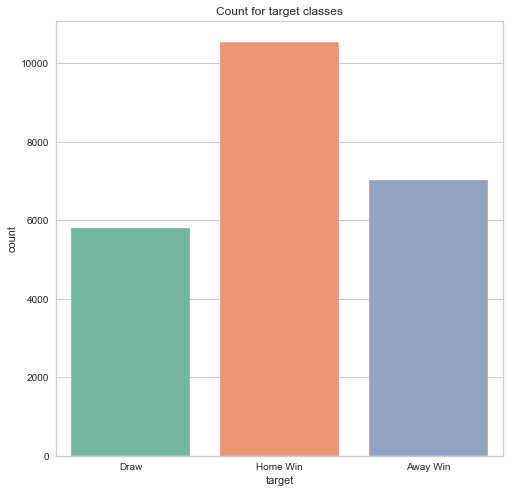

In [20]:
#plot the target to view the target class
plt.figure(figsize=(8,8))
ax=sns.countplot(x = soccer_data["target"],palette = 'Set2')
plt.title("Count for target classes")
labels=['Draw','Home Win','Away Win']
ax.set_xticklabels(labels)
plt.show()

Looking at the plot above, you can see that the data is slightly imbalance and it clearly shows that most matches always end with a home win. Now we will be looking at the features and visualizing how they correlate with the target while we check for multicollinearity.

# Data Visualization

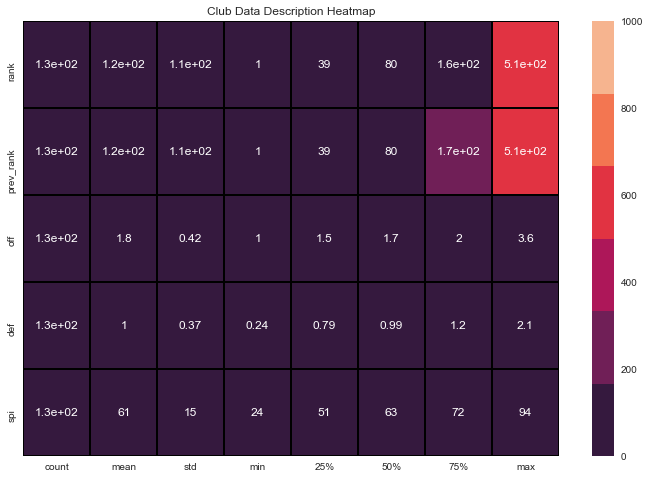

In [21]:
#let's visualize the club data description
plt.figure(figsize=(12,8))
ax=sns.heatmap(club_data.describe().transpose(),annot=True,fmt='.2g',
               linecolor='black',linewidths=1,vmin =0,vmax=1000,
               cmap=sns.color_palette('rocket'))
plt.title("Club Data Description Heatmap")
plt.show()

The club data tells us that the mean of the soccer power index of the team is 61 and the standard deviation of the previous rank of the teams and latest rank is 1. Let's look at the multicollinearity among the features on the soccer dataset.

Text(0.5, 1.0, 'MultiCollinearity Btw target and Features ')

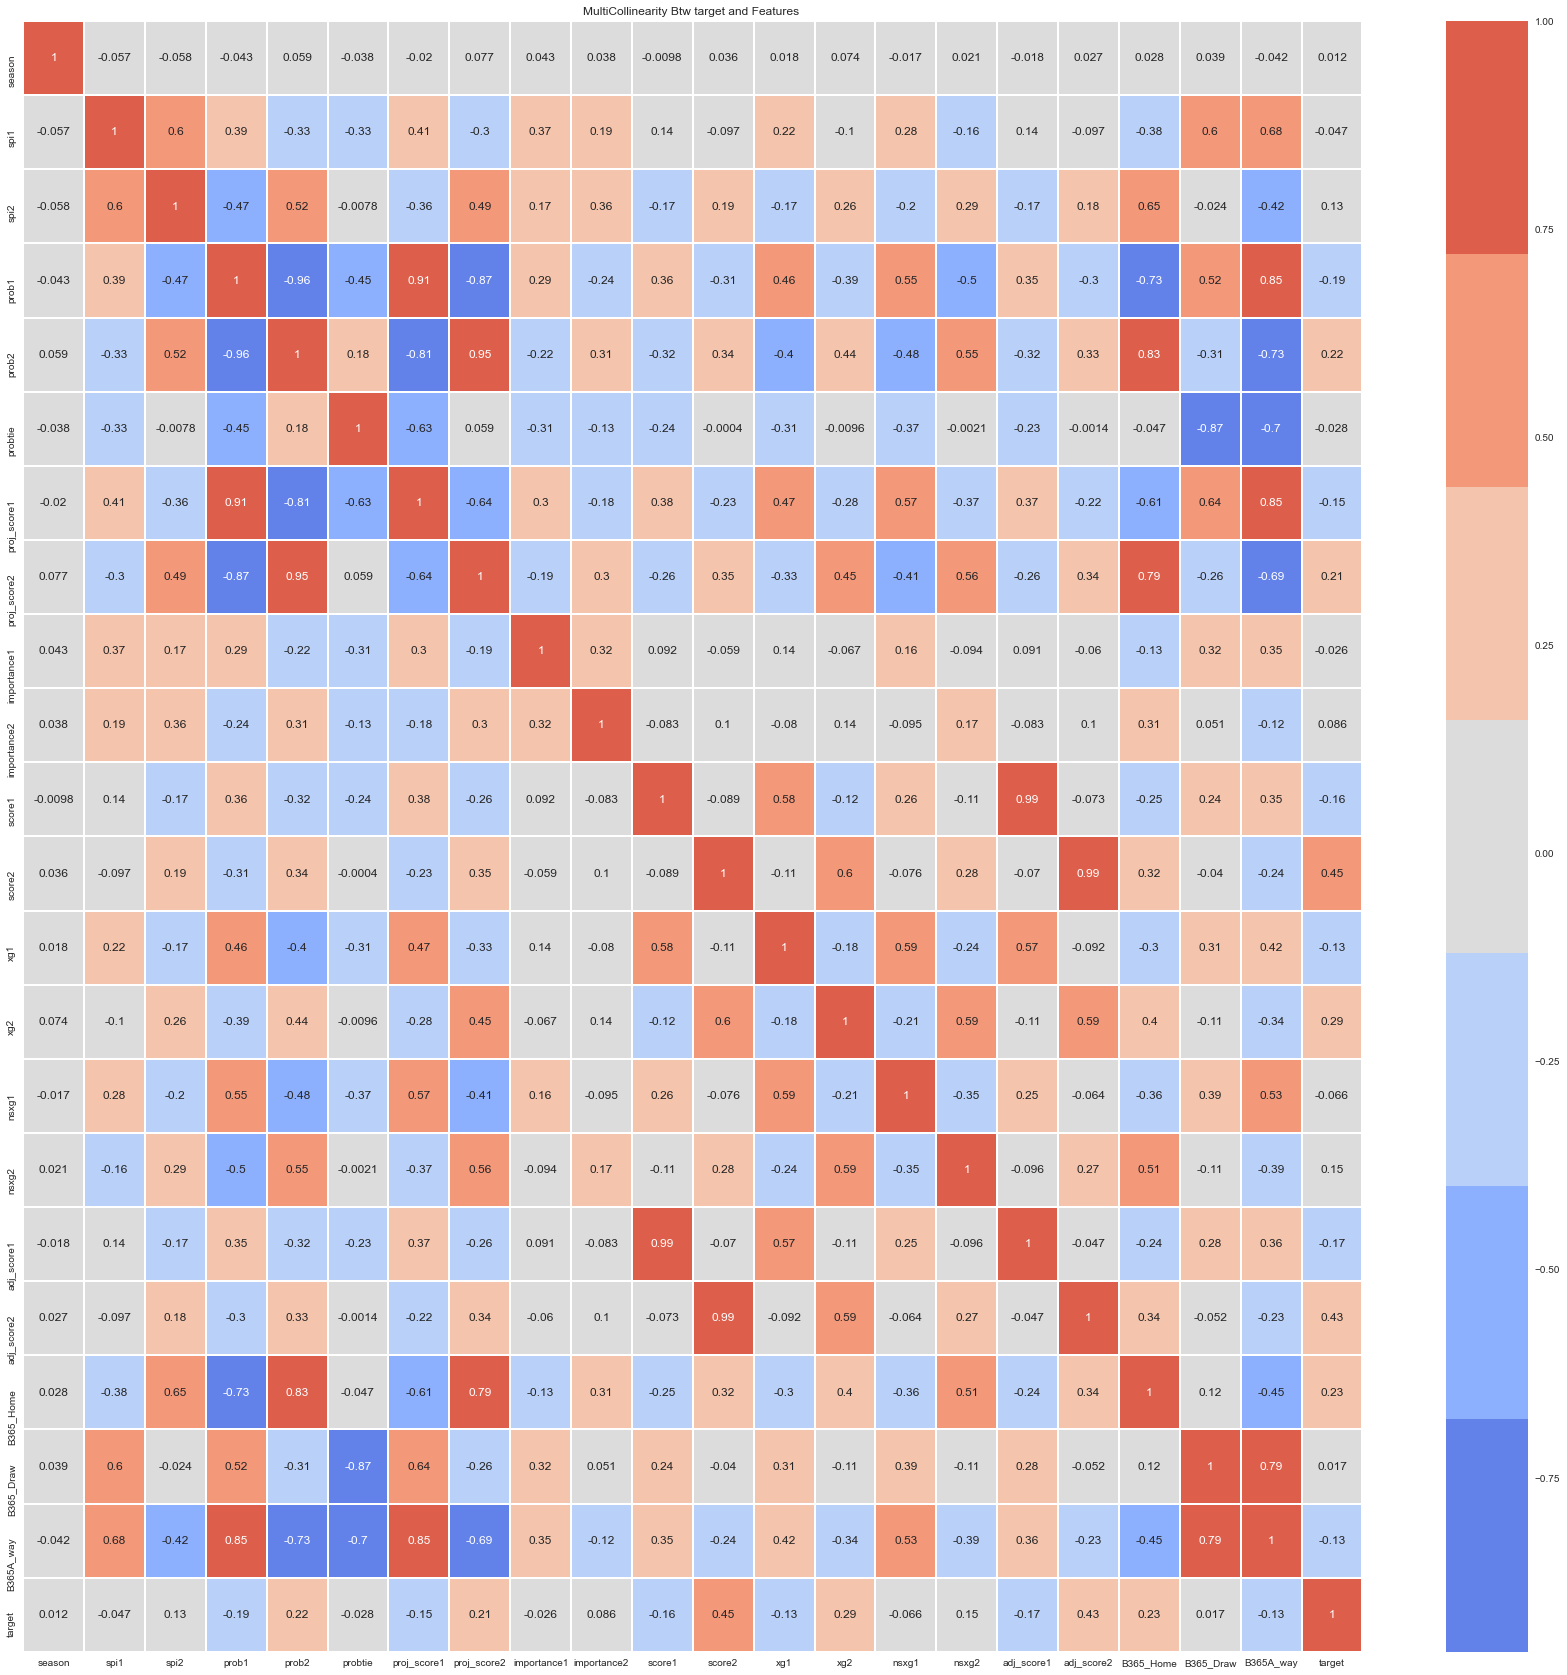

In [22]:
#let's visualize the multicolinearity among the features on soccer dataset
plt.figure(figsize=(30,30))
correlation = soccer_data.corr()
ax=sns.heatmap(correlation,annot=True,cmap =sns.color_palette('coolwarm',7),
              linewidths=1,linecolor='white')
plt.title("MultiCollinearity Btw target and Features ")

Looking at the table,there is multicollinearity between the scores and the adjusted scores. Also, there are some redundant columns that we need to drop because they will not add meaningful information to our model. I will drop the dates, nsxg1 and nsxg2, the projected scores due to the close correlation between the prob1 and prob2.

In [23]:
#drop redundant columns
soccer_final_df = soccer_data.drop(['date','nsxg1','nsxg2','proj_score1',
                                    'adj_score1','adj_score2','proj_score2',],axis =1)
soccer_final_df.head()

,season,league,team1,team2,spi1,spi2,prob1,prob2,probtie,importance1,importance2,score1,score2,xg1,xg2,B365_Home,B365_Draw,B365A_way,target
0,2016,French Ligue 1,Bastia,Paris Saint-Germain,51.16,85.68,0.0463,0.8380,0.1157,32.4,67.7,0.0,1.0,0.97,0.63,NaN,NaN,NaN,2
1,2016,French Ligue 1,AS Monaco,Guingamp,68.85,56.48,0.5714,0.1669,0.2617,53.7,22.9,2.0,2.0,2.45,0.77,NaN,NaN,NaN,0
2,2016,Barclays Premier League,Hull City,Leicester City,53.57,66.81,0.3459,0.3621,0.2921,38.1,22.2,2.0,1.0,0.85,2.77,NaN,NaN,NaN,1
3,2016,Barclays Premier League,Everton,Tottenham Hotspur,68.02,73.25,0.3910,0.3401,0.2689,31.9,48.0,1.0,1.0,0.73,1.11,NaN,NaN,NaN,0
4,2016,Barclays Premier League,Crystal Palace,West Bromwich Albion,55.19,58.66,0.4214,0.2939,0.2847,43.6,34.6,0.0,1.0,1.11,0.68,NaN,NaN,NaN,2


In [24]:
soccer_final_df.shape

(23390, 19)

In [25]:
#fill the nan value with 0 for the Bet365 odd columns
soccer_final_df.update(soccer_final_df[['B365_Home','B365_Draw','B365A_way']].fillna(0))

Text(0.5, 1.0, 'MultiCollinearity Btw target and Features ')

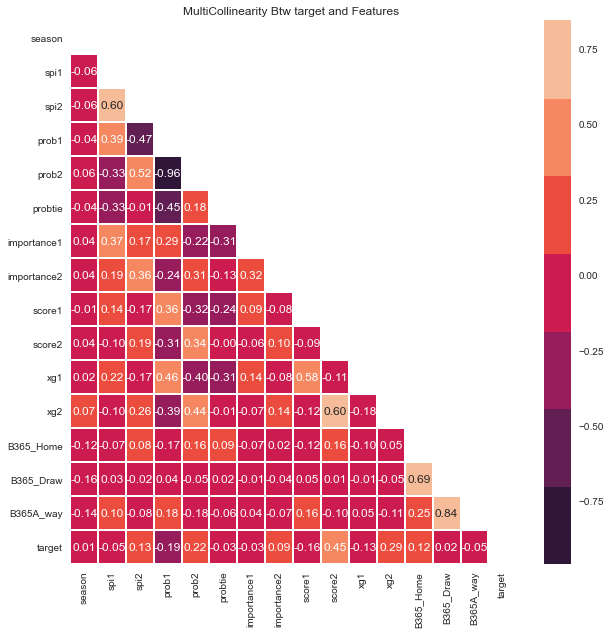

In [26]:
#plot the new dataframe to check multicollinearity
plt.figure(figsize = (10,10))
ax = sns.heatmap(soccer_final_df.corr(),mask =np.triu(np.ones_like(soccer_final_df.corr(),dtype = bool)), 
            annot = True,cmap =sns.color_palette('rocket',7),
            linewidths=1,linecolor='white',fmt='.2f')
plt.title("MultiCollinearity Btw target and Features ")

Now everything seems to be fine except for the bet365 odds, due to not having enough data, most of the columns is empty, even though I filled with zeros, there is not enough odds to use in processing the model. I will be dropping it aswell. 

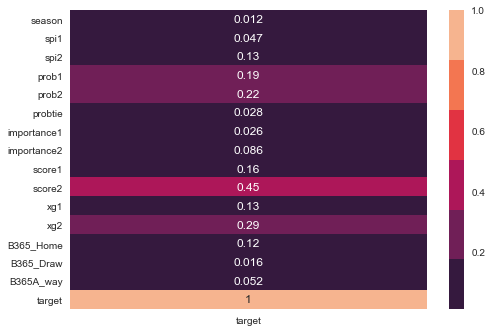

In [27]:
#checking to see the most correlated features
sns.heatmap(abs(soccer_final_df.corr())[['target']], annot = True,
            cmap =sns.color_palette('rocket'));

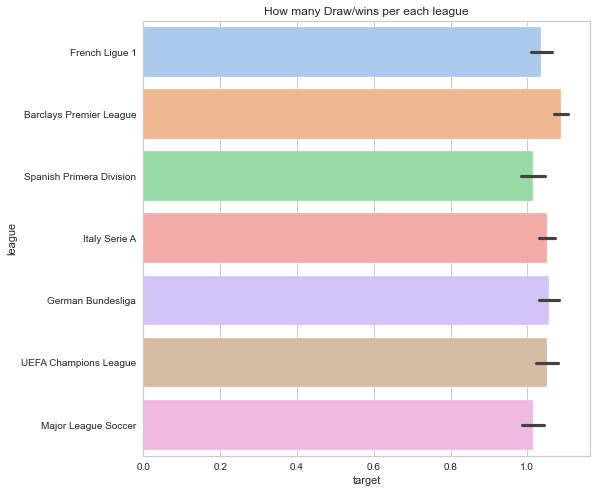

In [28]:
#plot a bargraph using the leagues to see how many times there is a draws/win
plt.figure(figsize=(8,8))
ax=sns.barplot(data = soccer_final_df,x ='target',y ='league',palette = 'pastel')
plt.title("How many Draw/wins per each league")
plt.show()

Looking at the above chart, it shows that most of the leagues win the game at home. We are going to look at the target again using the probability scores and probtie columns but before then we are going to drop the league column and some other columns that will not be needed for the analysis.

In [29]:
#drop more columns due to alot of nan values 
soccer_df = soccer_final_df.drop(['league','B365_Home','B365_Draw','B365A_way'],axis =1)
soccer_df = soccer_df.dropna().reset_index(drop=True)
soccer_df.head(10)

,season,team1,team2,spi1,spi2,prob1,prob2,probtie,importance1,importance2,score1,score2,xg1,xg2,target
0,2016,Bastia,Paris Saint-Germain,51.16,85.68,0.0463,0.8380,0.1157,32.4,67.7,0.0,1.0,0.97,0.63,2
1,2016,AS Monaco,Guingamp,68.85,56.48,0.5714,0.1669,0.2617,53.7,22.9,2.0,2.0,2.45,0.77,0
2,2016,Hull City,Leicester City,53.57,66.81,0.3459,0.3621,0.2921,38.1,22.2,2.0,1.0,0.85,2.77,1
3,2016,Everton,Tottenham Hotspur,68.02,73.25,0.3910,0.3401,0.2689,31.9,48.0,1.0,1.0,0.73,1.11,0
4,2016,Crystal Palace,West Bromwich Albion,55.19,58.66,0.4214,0.2939,0.2847,43.6,34.6,0.0,1.0,1.11,0.68,2
5,2016,Middlesbrough,Stoke City,56.32,60.35,0.4380,0.2692,0.2927,33.9,32.5,1.0,1.0,1.40,0.55,0
6,2016,Burnley,Swansea City,58.98,59.74,0.4482,0.2663,0.2854,36.5,29.1,0.0,1.0,1.24,1.84,2
7,2016,Southampton,Watford,69.49,59.33,0.5759,0.1874,0.2367,34.1,30.7,1.0,1.0,1.05,0.22,0
8,2016,Bordeaux,St Etienne,62.01,64.92,0.4232,0.2764,0.3004,37.9,44.2,3.0,2.0,1.03,1.84,1
9,2016,Manchester City,Sunderland,86.42,53.64,0.8152,0.0525,0.1323,73.0,27.0,2.0,1.0,2.14,1.25,1


In [30]:
soccer_df.tail(10)

,season,team1,team2,spi1,spi2,prob1,prob2,probtie,importance1,importance2,score1,score2,xg1,xg2,target
11884,2021,Borussia Monchengladbach,SpVgg Greuther Fürth,73.99,54.36,0.6454,0.1410,0.2136,41.2,30.5,4.0,0.0,2.20,0.31,1
11885,2021,Watford,Manchester United,59.62,80.86,0.1957,0.5770,0.2273,46.8,47.2,4.0,1.0,2.99,1.72,1
11886,2021,Burnley,Crystal Palace,65.84,71.28,0.3898,0.3436,0.2666,37.4,14.6,3.0,3.0,1.37,1.87,0
11887,2021,Newcastle,Brentford,61.00,69.45,0.3583,0.3789,0.2628,47.5,24.5,3.0,3.0,2.51,1.11,0
11888,2021,Norwich City,Southampton,55.19,69.71,0.2865,0.4382,0.2753,36.1,22.1,2.0,1.0,0.53,1.09,1
11889,2021,Aston Villa,Brighton and Hove Albion,70.01,76.08,0.3729,0.3578,0.2692,27.7,21.6,2.0,0.0,1.05,0.35,1
11890,2021,Wolverhampton,West Ham United,71.28,78.51,0.2841,0.4536,0.2623,12.7,59.5,1.0,0.0,1.44,0.42,1
11891,2021,Sevilla FC,Alavés,78.84,62.97,0.6454,0.1172,0.2374,70.4,28.3,2.0,2.0,1.46,1.41,0
11892,2021,Paris Saint-Germain,Nantes,81.85,58.75,0.7338,0.1002,0.1660,44.3,16.8,3.0,1.0,1.62,1.25,1
11893,2021,Lazio,Juventus,69.88,78.62,0.2984,0.4584,0.2432,51.4,73.0,0.0,2.0,0.34,2.73,2


In [31]:
#combine the home and away team to make a single team
#to avoid data leakeage.
soccer_df['team'] = soccer_df['team1'].combine_first(soccer_df['team2'])
soccer_df.head(10)

,season,team1,team2,spi1,spi2,prob1,prob2,probtie,importance1,importance2,score1,score2,xg1,xg2,target,team
0,2016,Bastia,Paris Saint-Germain,51.16,85.68,0.0463,0.8380,0.1157,32.4,67.7,0.0,1.0,0.97,0.63,2,Bastia
1,2016,AS Monaco,Guingamp,68.85,56.48,0.5714,0.1669,0.2617,53.7,22.9,2.0,2.0,2.45,0.77,0,AS Monaco
2,2016,Hull City,Leicester City,53.57,66.81,0.3459,0.3621,0.2921,38.1,22.2,2.0,1.0,0.85,2.77,1,Hull City
3,2016,Everton,Tottenham Hotspur,68.02,73.25,0.3910,0.3401,0.2689,31.9,48.0,1.0,1.0,0.73,1.11,0,Everton
4,2016,Crystal Palace,West Bromwich Albion,55.19,58.66,0.4214,0.2939,0.2847,43.6,34.6,0.0,1.0,1.11,0.68,2,Crystal Palace
5,2016,Middlesbrough,Stoke City,56.32,60.35,0.4380,0.2692,0.2927,33.9,32.5,1.0,1.0,1.40,0.55,0,Middlesbrough
6,2016,Burnley,Swansea City,58.98,59.74,0.4482,0.2663,0.2854,36.5,29.1,0.0,1.0,1.24,1.84,2,Burnley
7,2016,Southampton,Watford,69.49,59.33,0.5759,0.1874,0.2367,34.1,30.7,1.0,1.0,1.05,0.22,0,Southampton
8,2016,Bordeaux,St Etienne,62.01,64.92,0.4232,0.2764,0.3004,37.9,44.2,3.0,2.0,1.03,1.84,1,Bordeaux
9,2016,Manchester City,Sunderland,86.42,53.64,0.8152,0.0525,0.1323,73.0,27.0,2.0,1.0,2.14,1.25,1,Manchester City


In [32]:
#drop the team1 and team2 column
soccer_df = soccer_df.drop(['team1','team2',],axis =1)
soccer_df = soccer_df.reset_index(drop=True)
soccer_df.head(10)

,season,spi1,spi2,prob1,prob2,probtie,importance1,importance2,score1,score2,xg1,xg2,target,team
0,2016,51.16,85.68,0.0463,0.8380,0.1157,32.4,67.7,0.0,1.0,0.97,0.63,2,Bastia
1,2016,68.85,56.48,0.5714,0.1669,0.2617,53.7,22.9,2.0,2.0,2.45,0.77,0,AS Monaco
2,2016,53.57,66.81,0.3459,0.3621,0.2921,38.1,22.2,2.0,1.0,0.85,2.77,1,Hull City
3,2016,68.02,73.25,0.3910,0.3401,0.2689,31.9,48.0,1.0,1.0,0.73,1.11,0,Everton
4,2016,55.19,58.66,0.4214,0.2939,0.2847,43.6,34.6,0.0,1.0,1.11,0.68,2,Crystal Palace
5,2016,56.32,60.35,0.4380,0.2692,0.2927,33.9,32.5,1.0,1.0,1.40,0.55,0,Middlesbrough
6,2016,58.98,59.74,0.4482,0.2663,0.2854,36.5,29.1,0.0,1.0,1.24,1.84,2,Burnley
7,2016,69.49,59.33,0.5759,0.1874,0.2367,34.1,30.7,1.0,1.0,1.05,0.22,0,Southampton
8,2016,62.01,64.92,0.4232,0.2764,0.3004,37.9,44.2,3.0,2.0,1.03,1.84,1,Bordeaux
9,2016,86.42,53.64,0.8152,0.0525,0.1323,73.0,27.0,2.0,1.0,2.14,1.25,1,Manchester City


In [33]:
soccer_df.shape

(11894, 14)

In [34]:
len(soccer_df['season'])

11894

In [35]:
group_df = soccer_df.groupby(['target'],as_index=False)['team'].count().sort_values('target',ascending=False)
group_df.reset_index(drop=True,inplace=True)
group_df

,target,team
0,2,3561
1,1,5421
2,0,2912


Out of 11894 season in the league that I decided to analyze, 5421 of the teams always win at home while 3561 win at the away matches and 2912 draw either at home matches or Away matches.

In [36]:
soccer_df.isnull().sum()

season         0
spi1           0
spi2           0
prob1          0
prob2          0
probtie        0
importance1    0
importance2    0
score1         0
score2         0
xg1            0
xg2            0
target         0
team           0
dtype: int64

Now that we have been able to pare down the dataset,we can go ahead and plot a 3d plot that will show the full-time results using the predicted probabilities of a soccer game.

I will plot the distribution of the features to see if it is normal or skewed.

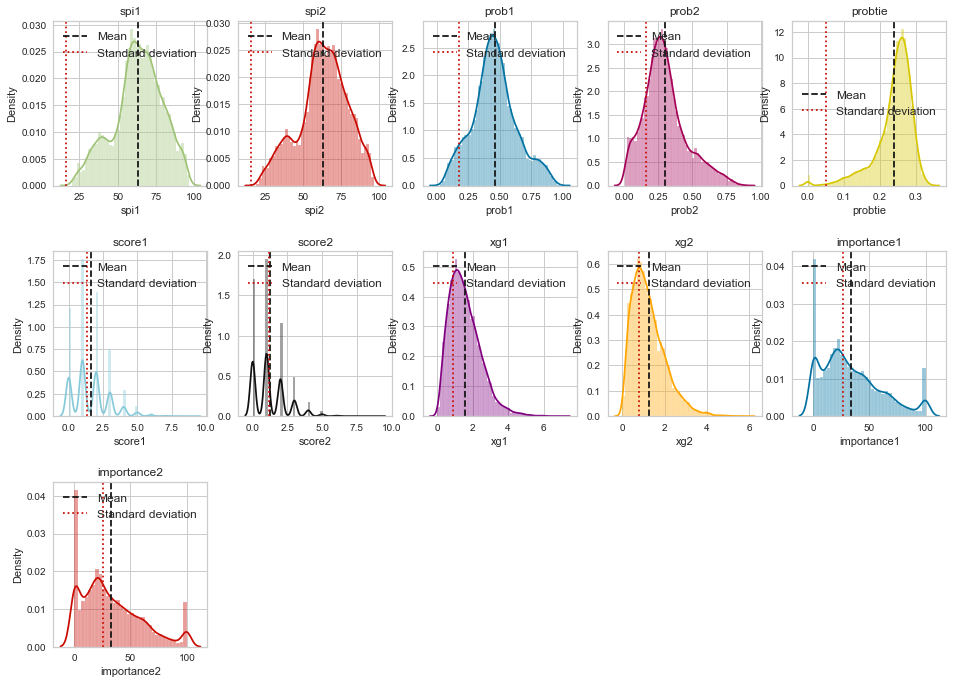

In [38]:
#plot distribution of all features
columns = ['spi1','spi2','prob1','prob2','probtie','score1','score2','xg1','xg2','importance1','importance2']
length = len(columns)
colors= ['g','r','b','m','y','c','k','purple','orange','b','r']

plt.figure(figsize=(16,20))
for i,j,k in itertools.zip_longest(columns,range(length),colors):
    plt.subplot(length/2,length/2, j+1)
    sns.distplot(soccer_df[i],color=k)
    plt.title(i)
    plt.subplots_adjust(hspace = .4)
    plt.axvline(soccer_df[i].mean(), color='k', linestyle='dashed',label='Mean')
    plt.axvline(soccer_df[i].std(), color='r', linestyle='dotted',label='Standard deviation')
    plt.legend(loc='best',prop={'size':12})

The SPIs and the Probs seems to follow almost a normal distribution, which is what we want actually. Now we are going to compare the features with the target using boxplots.

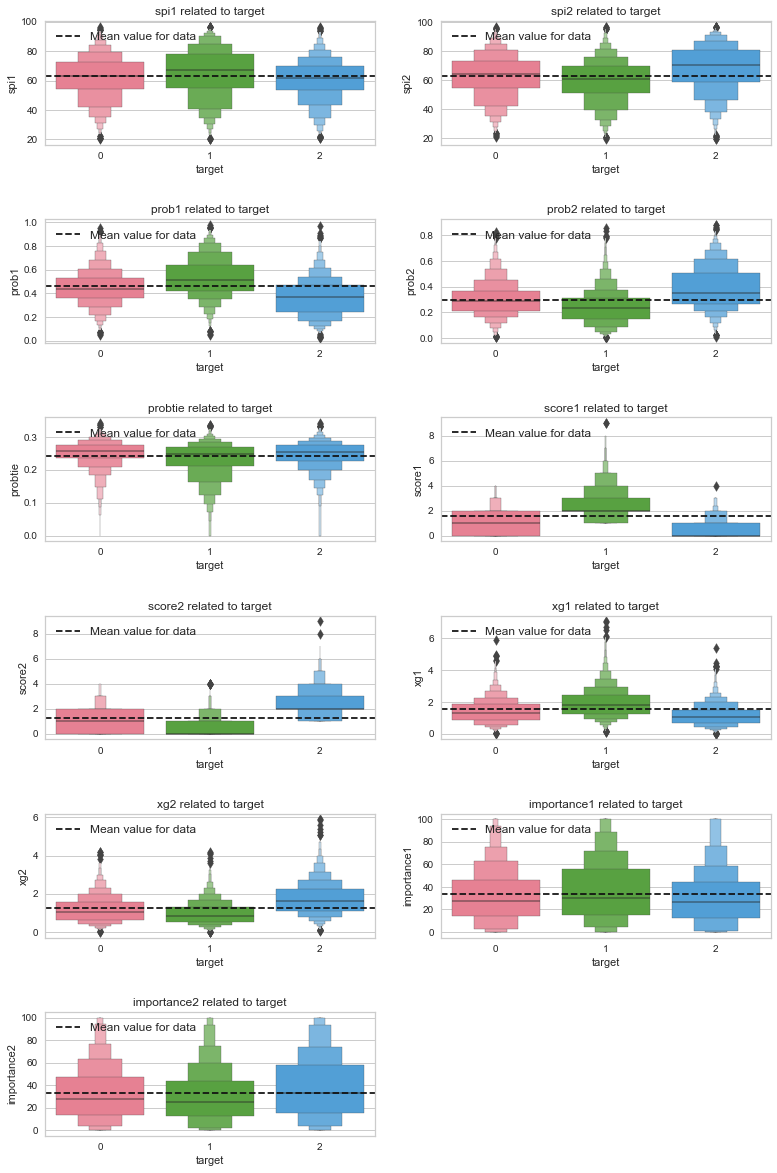

In [39]:
#visualize the target if it related to the correlated features
cols = ['spi1','spi2','prob1','prob2','probtie','score1','score2','xg1','xg2','importance1','importance2']

columns = [x for x in cols if x not in ['target_class']]
length = len(columns)

plt.figure(figsize=(13,18))
for i,j in itertools.zip_longest(columns,range(length)):
    plt.subplot(6,2,j+1)
    plt.subplots_adjust(bottom =1/50)
    sns.boxenplot(x=soccer_df['target'],y=soccer_df[i],palette = 'husl')
    plt.title(i + " related to target")
    plt.subplots_adjust(hspace = .6)
    plt.axhline(soccer_df[i].mean(), color='k', linestyle='dashed',label='Mean value for data')
    plt.legend(loc='upper left',prop={'size':12})

As you can see the EDA and visualization really tells us alot of information about the soccer dataset. Now I am going to use the features to build a predictive model that is going to prompt users for probability of the clubs winning the match either home or away.

## Modeling

My approach of modelling was using supervised Machine learning techniques to check the effectiveness of each performance metrics to analyze the dataset for accuracy. Although, different Machine learning models were considered for the project but I decide to use logistic Regression as my baseline model so that I can use it to compare the accuracy of the other models.

I also compare different models using the mean and standard deviation of the accuracy scores. The scores were lower than the baseline score especially the KNN algorithm. Then I went ahead using gridsearchCV to tune each model for a better result while minimizing the loss function.



In [40]:
#bring in the saved cleaned soccer data 
soccer_df = pd.read_csv("Data/soccer-spi/soccer_df.csv",index_col=0)
club_data = pd.read_csv("Data/soccer-spi/club_data.csv",index_col=0)

In [41]:
soccer_df.head(10)

,season,spi1,spi2,prob1,prob2,probtie,importance1,importance2,score1,score2,xg1,xg2,target,team
0,2016,51.16,85.68,0.0463,0.8380,0.1157,32.4,67.7,0.0,1.0,0.97,0.63,2,Bastia
1,2016,68.85,56.48,0.5714,0.1669,0.2617,53.7,22.9,2.0,2.0,2.45,0.77,0,AS Monaco
2,2016,53.57,66.81,0.3459,0.3621,0.2921,38.1,22.2,2.0,1.0,0.85,2.77,1,Hull City
3,2016,68.02,73.25,0.3910,0.3401,0.2689,31.9,48.0,1.0,1.0,0.73,1.11,0,Everton
4,2016,55.19,58.66,0.4214,0.2939,0.2847,43.6,34.6,0.0,1.0,1.11,0.68,2,Crystal Palace
5,2016,56.32,60.35,0.4380,0.2692,0.2927,33.9,32.5,1.0,1.0,1.40,0.55,0,Middlesbrough
6,2016,58.98,59.74,0.4482,0.2663,0.2854,36.5,29.1,0.0,1.0,1.24,1.84,2,Burnley
7,2016,69.49,59.33,0.5759,0.1874,0.2367,34.1,30.7,1.0,1.0,1.05,0.22,0,Southampton
8,2016,62.01,64.92,0.4232,0.2764,0.3004,37.9,44.2,3.0,2.0,1.03,1.84,1,Bordeaux
9,2016,86.42,53.64,0.8152,0.0525,0.1323,73.0,27.0,2.0,1.0,2.14,1.25,1,Manchester City


In [42]:
soccer_df.tail(10)

,season,spi1,spi2,prob1,prob2,probtie,importance1,importance2,score1,score2,xg1,xg2,target,team
11884,2021,73.99,54.36,0.6454,0.1410,0.2136,41.2,30.5,4.0,0.0,2.20,0.31,1,Borussia Monchengladbach
11885,2021,59.62,80.86,0.1957,0.5770,0.2273,46.8,47.2,4.0,1.0,2.99,1.72,1,Watford
11886,2021,65.84,71.28,0.3898,0.3436,0.2666,37.4,14.6,3.0,3.0,1.37,1.87,0,Burnley
11887,2021,61.00,69.45,0.3583,0.3789,0.2628,47.5,24.5,3.0,3.0,2.51,1.11,0,Newcastle
11888,2021,55.19,69.71,0.2865,0.4382,0.2753,36.1,22.1,2.0,1.0,0.53,1.09,1,Norwich City
11889,2021,70.01,76.08,0.3729,0.3578,0.2692,27.7,21.6,2.0,0.0,1.05,0.35,1,Aston Villa
11890,2021,71.28,78.51,0.2841,0.4536,0.2623,12.7,59.5,1.0,0.0,1.44,0.42,1,Wolverhampton
11891,2021,78.84,62.97,0.6454,0.1172,0.2374,70.4,28.3,2.0,2.0,1.46,1.41,0,Sevilla FC
11892,2021,81.85,58.75,0.7338,0.1002,0.1660,44.3,16.8,3.0,1.0,1.62,1.25,1,Paris Saint-Germain
11893,2021,69.88,78.62,0.2984,0.4584,0.2432,51.4,73.0,0.0,2.0,0.34,2.73,2,Lazio


In [43]:
club_data.head(10)

,rank,prev_rank,name,league,off,def,spi
0,1,1,Bayern Munich,German Bundesliga,3.64,0.51,93.72
1,2,2,Manchester City,Barclays Premier League,2.97,0.24,93.57
2,3,3,Liverpool,Barclays Premier League,3.06,0.46,91.04
3,4,4,Chelsea,Barclays Premier League,2.47,0.24,90.32
5,6,6,Real Madrid,Spanish Primera Division,2.57,0.62,84.21
6,7,8,Internazionale,Italy Serie A,2.59,0.66,83.64
7,8,9,Atletico Madrid,Spanish Primera Division,2.29,0.51,83.19
8,9,10,Barcelona,Spanish Primera Division,2.44,0.62,82.68
9,10,7,RB Leipzig,German Bundesliga,2.53,0.70,82.23
10,11,11,Paris Saint-Germain,French Ligue 1,2.52,0.75,81.16


In [44]:
soccer_df.shape , club_data.shape

((11894, 14), (128, 7))

In [45]:
#check the data info
soccer_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11894 entries, 0 to 11893
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   season       11894 non-null  int64  
 1   spi1         11894 non-null  float64
 2   spi2         11894 non-null  float64
 3   prob1        11894 non-null  float64
 4   prob2        11894 non-null  float64
 5   probtie      11894 non-null  float64
 6   importance1  11894 non-null  float64
 7   importance2  11894 non-null  float64
 8   score1       11894 non-null  float64
 9   score2       11894 non-null  float64
 10  xg1          11894 non-null  float64
 11  xg2          11894 non-null  float64
 12  target       11894 non-null  int64  
 13  team         11894 non-null  object 
dtypes: float64(11), int64(2), object(1)
memory usage: 1.4+ MB


In [46]:
#let's drop the team and the score columns to avoid data leakeage
soccer_final= soccer_df.drop(['team','score1','score2'],axis =1)
soccer_final.head(10)

,season,spi1,spi2,prob1,prob2,probtie,importance1,importance2,xg1,xg2,target
0,2016,51.16,85.68,0.0463,0.8380,0.1157,32.4,67.7,0.97,0.63,2
1,2016,68.85,56.48,0.5714,0.1669,0.2617,53.7,22.9,2.45,0.77,0
2,2016,53.57,66.81,0.3459,0.3621,0.2921,38.1,22.2,0.85,2.77,1
3,2016,68.02,73.25,0.3910,0.3401,0.2689,31.9,48.0,0.73,1.11,0
4,2016,55.19,58.66,0.4214,0.2939,0.2847,43.6,34.6,1.11,0.68,2
5,2016,56.32,60.35,0.4380,0.2692,0.2927,33.9,32.5,1.40,0.55,0
6,2016,58.98,59.74,0.4482,0.2663,0.2854,36.5,29.1,1.24,1.84,2
7,2016,69.49,59.33,0.5759,0.1874,0.2367,34.1,30.7,1.05,0.22,0
8,2016,62.01,64.92,0.4232,0.2764,0.3004,37.9,44.2,1.03,1.84,1
9,2016,86.42,53.64,0.8152,0.0525,0.1323,73.0,27.0,2.14,1.25,1


In [47]:
#final data description
soccer_final.describe()

,season,spi1,spi2,prob1,prob2,probtie,importance1,importance2,xg1,xg2,target
count,11894.000000,11894.000000,11894.000000,11894.000000,11894.000000,11894.000000,11894.000000,11894.000000,11894.000000,11894.000000,11894.000000
mean,2018.384311,63.113665,63.008944,0.460707,0.298403,0.240891,33.797671,33.026745,1.568090,1.247501,1.054565
std,1.547051,15.960783,16.046702,0.174603,0.158399,0.050365,26.300869,25.986937,0.885049,0.780674,0.735726
min,2016.000000,19.990000,19.290000,0.027000,0.003700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2017.000000,54.370000,54.212500,0.353725,0.195400,0.222600,14.000000,13.300000,0.910000,0.670000,1.000000
50%,2018.000000,63.960000,63.920000,0.453350,0.277150,0.252000,28.500000,27.500000,1.430000,1.100000,1.000000
75%,2020.000000,74.267500,74.160000,0.559175,0.374175,0.273400,49.100000,49.000000,2.080000,1.670000,2.000000
max,2021.000000,96.570000,96.690000,0.977500,0.881600,0.342300,100.000000,100.000000,7.070000,5.900000,2.000000


In [48]:
soccer_final.shape

(11894, 11)

In [49]:
#Define X and y
X = soccer_final.drop('target', axis =1)
y = soccer_final['target']

#holdout set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.15,random_state=42)

#training and test set
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.20,random_state=42)

In [50]:
X.columns

Index(['season', 'spi1', 'spi2', 'prob1', 'prob2', 'probtie', 'importance1',
       'importance2', 'xg1', 'xg2'],
      dtype='object')

In [51]:
y.value_counts(normalize=True)

1    0.455776
2    0.299395
0    0.244829
Name: target, dtype: float64

In [52]:
#normalize the features
scaler = MinMaxScaler()
scaled = scaler.fit(X_train)

X_train_scaled = scaled.transform(X_train)
X_test_scaled = scaled.transform(X_test)
X_val_scaled =scaled.transform(X_val)

In [53]:
X_train_scaled.shape, X_test_scaled.shape , X_val.shape

((8087, 10), (2022, 10), (1785, 10))

In [54]:
y_train.shape , y_test.shape , y_val.shape

((8087,), (2022,), (1785,))

### Baseline Understanding

I will be building a baseline model to compare with the other models using the accuracy score. The goal is to improve the score and at the end predict on unseen data to beat the bookmaker's odds.

In [55]:
scoring =['accuracy','f1_weighted']

In [56]:
#instantiate the Decision Tree classifier
baseline_model = DecisionTreeClassifier()
baseline_model.fit(X_train_scaled,y_train)

DecisionTreeClassifier()

In [57]:
cross_validate(baseline_model,X_train_scaled, y_train,scoring=scoring)

{'fit_time': array([0.05368185, 0.06708312, 0.05889106, 0.05960011, 0.05729318]),
 'score_time': array([0.00194621, 0.0020988 , 0.00214195, 0.00248289, 0.00181985]),
 'test_accuracy': array([0.4789864 , 0.4697157 , 0.44774273, 0.4681509 , 0.48423006]),
 'test_f1_weighted': array([0.48016089, 0.46981996, 0.4502151 , 0.46915199, 0.48618547])}

Training Scores:
Accuracy Score: 1.0
----
Log loss Score: 2.1094237467877998e-15
----
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1983
           1       1.00      1.00      1.00      3671
           2       1.00      1.00      1.00      2433

    accuracy                           1.00      8087
   macro avg       1.00      1.00      1.00      8087
weighted avg       1.00      1.00      1.00      8087

------------
Test Scores:
Accuracy Score: 0.47032640949554894
----
Log loss Score: 18.29427770472272
----
              precision    recall  f1-score   support

           0       0.26      0.25      0.25       508
           1       0.60      0.58      0.59       925
           2       0.45      0.49      0.47       589

    accuracy                           0.47      2022
   macro avg       0.44      0.44      0.44      2022
weighted avg       0.47      0.47      0.47      2022



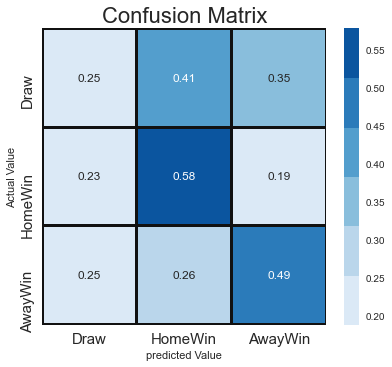

In [58]:
evaluate_model(baseline_model, X_train_scaled, X_test_scaled, y_train, y_test)

The baseline model was overfitting on the training data, while able to predict an accuracy score of 47% on the test set with a probability of loss at -18.0. With this information, I will go ahead and build more models in order to compare the results with the baseline model.

### First Models without parameters

Here, I will build different types of model without a parameter then compare it against the baseline model. The results will help to decide how to tune each model for better score.

In [59]:
#prepare models
models =[]
models.append(('knn model',KNeighborsClassifier()))
models.append(('Logistic model',LogisticRegression()))
models.append(('Random forest',RandomForestClassifier()))
models.append(('Naive Bayes',GaussianNB()))
models.append(('xgboost',XGBClassifier()))
models.append(('SVC model',SVC()))

#evaluate each models
results=[]
names=[]
df=[]

target=['draw','HomeWin','AwayWin']
for name, model in models:
    Kfold = KFold(n_splits=2, random_state=200, shuffle=True)
    cv_results = cross_validate(model,X_train_scaled, y_train,cv=5,scoring=scoring)
    model_fit = model.fit(X_train_scaled,y_train)
    pred = model_fit.predict(X_test_scaled)
    print(name)
    print(classification_report(y_test,pred,target_names=target))
    
    #append results
    results.append(cv_results)
    names.append(name)
    
    #put results in dataframe
    data = pd.DataFrame(cv_results)
    data['model']=name
    df.append(data)
    
    final = pd.concat(df,ignore_index=True)
    print(final)

knn model
              precision    recall  f1-score   support

        draw       0.30      0.32      0.31       508
     HomeWin       0.59      0.66      0.63       925
     AwayWin       0.55      0.42      0.48       589

    accuracy                           0.51      2022
   macro avg       0.48      0.47      0.47      2022
weighted avg       0.51      0.51      0.50      2022

   fit_time  score_time  test_accuracy  test_f1_weighted      model
0  0.004737    0.085264       0.516069          0.513538  knn model
1  0.004475    0.083662       0.518541          0.513672  knn model
2  0.004857    0.081232       0.504638          0.503946  knn model
3  0.004640    0.083525       0.499691          0.493908  knn model
4  0.004435    0.086391       0.498454          0.494914  knn model
Logistic model
              precision    recall  f1-score   support

        draw       0.28      0.03      0.06       508
     HomeWin       0.61      0.85      0.71       925
     AwayWin       0.56

Firstly, I create a variable dataframe to hold all of the datasets that will be created from the application of 5-fold cross validation on the training set. Next, models in a list of tuples holding the name and class for each classifier to be tested. After this, I loop through this list and run 5-fold cross validation. The results of each run are recorded in a pandas dataframe which I append to the dataframe list. Please note that the metrics recorded here are weighted mean metrics across both classes. The SVC Model and LR model seems to be performing better than other models with a score of 59% even though it is yet to be hypertune. While the KNN model seems to be performing less but better than the baseline. With this information I will go ahead to tune each model using gridsearchCV and then predict the scores on both train and test set.

To better obtain the estimate of the distribution of metrics of each model I run a bootstrap of 30 samples and sort according to performance metrics and fit-time metrics.

In [60]:
#obtain bootstrap of metrics and fit-time metrics
"source:https://machinelearningmastery.com/"
    
num_samples= []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    sample= model_df.sample(n=30, replace=True)
    num_samples.append(sample)
        
sample_df = pd.concat(num_samples, ignore_index=True)
results_df= pd.melt(sample_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
# performance metrics
results_nofit = results_df.loc[~results_df['metrics'].isin(time_metrics)] 
# get df without fit data
results_nofit = results_nofit.sort_values(by='values')
# time metrics
results_fit = results_df.loc[results_df['metrics'].isin(time_metrics)] 
# df with fit data
results_fit = results_fit.sort_values(by='values')

Now I am going to visualize the models by it's  performance metrics 

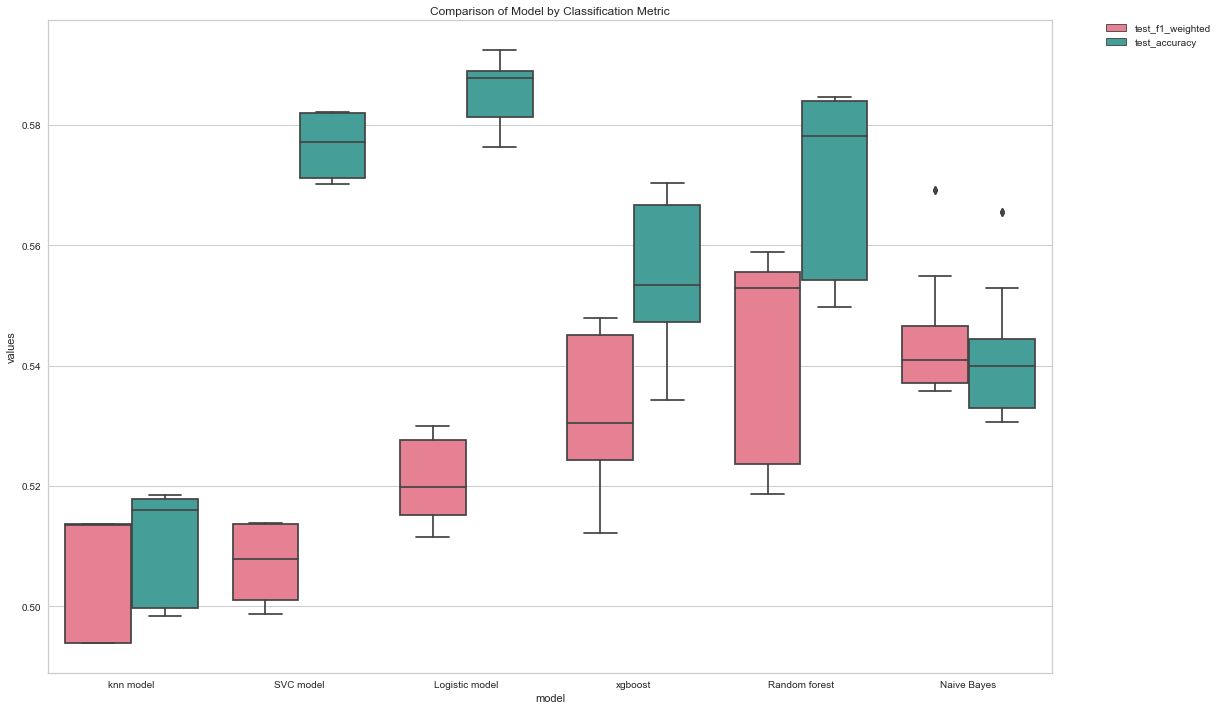

In [61]:
#plot a boxplot to compare the models
fig=plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111)
ax=sns.boxplot(x="model", y="values", hue="metrics", data=results_nofit, palette="husl")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
plt.show()

Looking at the boxplot it is clear that the SVC seems to perform well on the test data.

### Modeling Iterations using Pipeline and GridsearchCV .

Now I will go ahead and iterate through each model with different parameters and see if the models will perform better on unseen data.

- ####  Logistic Regression model with GridsearchCV

In [62]:
#instantiate a pipeline with the steps
lg_model = Pipeline(steps=[('classifier', LogisticRegression(multi_class="multinomial"))])
lg_model

Pipeline(steps=[('classifier', LogisticRegression(multi_class='multinomial'))])

In [63]:
#use the gini and entropy as the criterion
#use the max_depth
#use best splitter
param = [{ 
    'classifier__penalty':['l2','elasticnet'],
    'classifier__C':[1.5,1.0,2.0,2.5,5.0,6.0],
    'classifier__max_iter':[50,100,200],
    'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']}]

grid = GridSearchCV(estimator= lg_model,
                    param_grid = param, scoring='accuracy',cv =5)

In [64]:
#fit the grid on the training dataset
output = grid.fit(X_train_scaled, y_train)
#put the results in a dataframe
pd.DataFrame(output.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__max_iter,param_classifier__penalty,param_classifier__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.135159,0.014313,0.000563,0.000044,1.5,50,l2,newton-cg,"{'classifier__C': 1.5, 'classifier__max_iter':...",0.590235,0.585909,0.580705,0.574521,0.593074,0.584889,0.006658,46
1,0.079894,0.002223,0.000517,0.000015,1.5,50,l2,lbfgs,"{'classifier__C': 1.5, 'classifier__max_iter':...",0.588999,0.587763,0.580087,0.573902,0.592455,0.584641,0.006721,54
2,0.000977,0.000228,0.000000,0.000000,1.5,50,l2,liblinear,"{'classifier__C': 1.5, 'classifier__max_iter':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,113
3,0.057265,0.003035,0.000493,0.000029,1.5,50,l2,sag,"{'classifier__C': 1.5, 'classifier__max_iter':...",0.590235,0.585909,0.580087,0.574521,0.593074,0.584765,0.006739,53
4,0.000468,0.000035,0.000000,0.000000,1.5,50,elasticnet,newton-cg,"{'classifier__C': 1.5, 'classifier__max_iter':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.096935,0.006857,0.000598,0.000012,6,200,l2,sag,"{'classifier__C': 6.0, 'classifier__max_iter':...",0.591471,0.587763,0.580705,0.577613,0.593692,0.586249,0.006169,2
140,0.000482,0.000065,0.000000,0.000000,6,200,elasticnet,newton-cg,"{'classifier__C': 6.0, 'classifier__max_iter':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,56
141,0.000439,0.000003,0.000000,0.000000,6,200,elasticnet,lbfgs,"{'classifier__C': 6.0, 'classifier__max_iter':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,65
142,0.000450,0.000027,0.000000,0.000000,6,200,elasticnet,liblinear,"{'classifier__C': 6.0, 'classifier__max_iter':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,126


In [65]:
#check the best parameter
output.best_params_

{'classifier__C': 5.0,
 'classifier__max_iter': 100,
 'classifier__penalty': 'l2',
 'classifier__solver': 'lbfgs'}

In [66]:
#check the best score for the parameter
output.best_score_

0.5862487797681158

Training Scores:
Accuracy Score: 0.5864968467911463
----
Log loss Score: 0.8892859638690519
----
              precision    recall  f1-score   support

           0       0.43      0.05      0.10      1983
           1       0.60      0.84      0.70      3671
           2       0.58      0.64      0.61      2433

    accuracy                           0.59      8087
   macro avg       0.54      0.51      0.47      8087
weighted avg       0.55      0.59      0.52      8087

------------
Test Scores:
Accuracy Score: 0.582591493570722
----
Log loss Score: 0.8943080122910364
----
              precision    recall  f1-score   support

           0       0.32      0.04      0.07       508
           1       0.61      0.85      0.71       925
           2       0.56      0.63      0.59       589

    accuracy                           0.58      2022
   macro avg       0.49      0.51      0.46      2022
weighted avg       0.52      0.58      0.52      2022



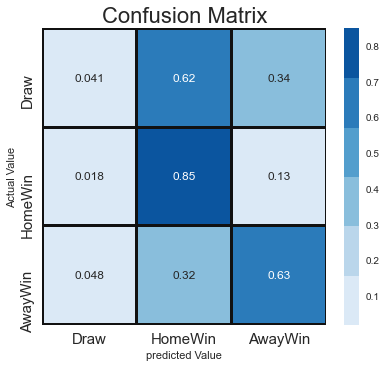

In [67]:
#evaluate the model on the train and test set
evaluate_model(output.best_estimator_, X_train_scaled, X_test_scaled, y_train, y_test)

After tunning the Logistic model using penalty, C and different solvers the model was able to perform better than the baseline model with an accuracy score of 59%. Even though the recall is high for the Homewin, the probability of loss is stil at -0.9 .

- #### Random Forest model with GridsearchCV

In [68]:
#instantiate a pipeline with the steps
Random_forest = Pipeline(steps=[('classifier', RandomForestClassifier())])
Random_forest

Pipeline(steps=[('classifier', RandomForestClassifier())])

In [69]:
param = [{
    'classifier__criterion':['gini','entropy'],
    'classifier__max_features':['sqrt','log2'],
    'classifier__class_weight':["balanced_subsample"],
    'classifier__max_depth': [5,10,50,100],
    'classifier__min_samples_split':[10,20,100,]}]

grid = GridSearchCV(estimator= Random_forest,
                    param_grid = param, scoring='accuracy',cv=5)

In [70]:
#fit the grid on the training dataset
output = grid.fit(X_train_scaled, y_train)
#put the results in a dataframe
pd.DataFrame(output.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__class_weight,param_classifier__criterion,param_classifier__max_depth,param_classifier__max_features,param_classifier__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.729307,0.017348,0.018896,0.000762,balanced_subsample,gini,5,sqrt,10,{'classifier__class_weight': 'balanced_subsamp...,0.562423,0.567985,0.533704,0.547928,0.551639,0.552736,0.011941,45
1,0.712333,0.010373,0.018123,0.000065,balanced_subsample,gini,5,sqrt,20,{'classifier__class_weight': 'balanced_subsamp...,0.559333,0.571693,0.526902,0.540507,0.547928,0.549273,0.015382,48
2,0.710312,0.004018,0.018490,0.000568,balanced_subsample,gini,5,sqrt,100,{'classifier__class_weight': 'balanced_subsamp...,0.564895,0.562423,0.541126,0.555349,0.544218,0.553602,0.009509,44
3,0.722144,0.009659,0.018733,0.001289,balanced_subsample,gini,5,log2,10,{'classifier__class_weight': 'balanced_subsamp...,0.558714,0.564277,0.538033,0.548547,0.549165,0.551747,0.009061,46
4,0.737985,0.021652,0.018954,0.000657,balanced_subsample,gini,5,log2,20,{'classifier__class_weight': 'balanced_subsamp...,0.562423,0.576020,0.542362,0.553494,0.547928,0.556445,0.011819,36
5,0.721184,0.004377,0.019200,0.000721,balanced_subsample,gini,5,log2,100,{'classifier__class_weight': 'balanced_subsamp...,0.561805,0.565513,0.528139,0.554731,0.542362,0.550510,0.013692,47
6,1.093712,0.009699,0.025426,0.001260,balanced_subsample,gini,10,sqrt,10,{'classifier__class_weight': 'balanced_subsamp...,0.574784,0.575402,0.549784,0.559678,0.558442,0.563618,0.009972,17
7,1.096312,0.017653,0.024932,0.001354,balanced_subsample,gini,10,sqrt,20,{'classifier__class_weight': 'balanced_subsamp...,0.582200,0.576020,0.545455,0.556586,0.557205,0.563493,0.013561,20
8,0.947316,0.005282,0.055951,0.065188,balanced_subsample,gini,10,sqrt,100,{'classifier__class_weight': 'balanced_subsamp...,0.564277,0.561187,0.536178,0.558442,0.549784,0.553973,0.010123,43
9,1.097572,0.042459,0.025009,0.000639,balanced_subsample,gini,10,log2,10,{'classifier__class_weight': 'balanced_subsamp...,0.566749,0.567985,0.554731,0.556586,0.560915,0.561393,0.005289,24


In [71]:
output.best_params_

{'classifier__class_weight': 'balanced_subsample',
 'classifier__criterion': 'entropy',
 'classifier__max_depth': 100,
 'classifier__max_features': 'log2',
 'classifier__min_samples_split': 10}

In [72]:
#check the best score for the parameter
output.best_score_

0.5719031336548553

Training Scores:
Accuracy Score: 0.9577099047854581
----
Log loss Score: 0.45610053003958695
----
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1983
           1       0.97      0.95      0.96      3671
           2       0.92      0.96      0.94      2433

    accuracy                           0.96      8087
   macro avg       0.96      0.96      0.96      8087
weighted avg       0.96      0.96      0.96      8087

------------
Test Scores:
Accuracy Score: 0.5583580613254204
----
Log loss Score: 0.9255786085054365
----
              precision    recall  f1-score   support

           0       0.33      0.21      0.26       508
           1       0.65      0.72      0.68       925
           2       0.52      0.61      0.56       589

    accuracy                           0.56      2022
   macro avg       0.50      0.51      0.50      2022
weighted avg       0.53      0.56      0.54      2022



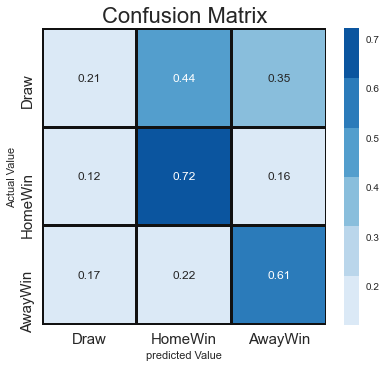

In [73]:
#evaluate the model on the train and test set
evaluate_model(output.best_estimator_,X_train_scaled,X_test_scaled,y_train,y_test)

There is a 2% slight change in the accuracy score for the Random forest model, but still better than the baseline single decision tree.

- #### XGBoost model using the gridsearchCV

In [74]:
#instantiate a pipeline with the steps
xgb_model= Pipeline(steps=[('pca',PCA()),
                           ('classifier', XGBClassifier(objective='multi:softmax'))])
xgb_model

Pipeline(steps=[('pca', PCA()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, gamma=None, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softmax', random_state=None,
                               reg_alpha=None, reg_lambda=None,
                               scale_pos_weight=None, subsample=None,
                               tree_method=None, validate_parameters=None,
                 

In [75]:
#set the parameters
param = [{
    'pca__n_components':[5,10],
    'classifier__gamma':[0.5,0.1],
    'classifier__max_depth': [10,20,50],
    'classifier__n_estimators':[20,60,100]}]

grid = GridSearchCV(estimator = xgb_model,
                    param_grid = param, scoring='accuracy',cv=5)

In [76]:
#fit the grid on the training dataset
output = grid.fit(X_train_scaled, y_train)
#put the results in a dataframe
pd.DataFrame(output.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__gamma,param_classifier__max_depth,param_classifier__n_estimators,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.228193,0.019627,0.003015,0.000028,0.5,10,20,5,"{'classifier__gamma': 0.5, 'classifier__max_de...",0.509271,0.520396,0.529375,0.510823,0.523810,0.518735,0.007667,20
1,0.358753,0.014804,0.003321,0.000022,0.5,10,20,10,"{'classifier__gamma': 0.5, 'classifier__max_de...",0.561187,0.582818,0.568336,0.560915,0.555968,0.565845,0.009358,2
2,0.652722,0.043561,0.006416,0.000928,0.5,10,60,5,"{'classifier__gamma': 0.5, 'classifier__max_de...",0.504326,0.515451,0.513296,0.502165,0.497217,0.506491,0.006870,21
3,1.151524,0.045717,0.006778,0.000605,0.5,10,60,10,"{'classifier__gamma': 0.5, 'classifier__max_de...",0.564895,0.574784,0.562152,0.549165,0.552257,0.560651,0.009191,12
4,1.134470,0.057410,0.008599,0.000981,0.5,10,100,5,"{'classifier__gamma': 0.5, 'classifier__max_de...",0.497528,0.515451,0.508967,0.501546,0.498454,0.504389,0.006837,23
5,1.968656,0.044086,0.010070,0.003476,0.5,10,100,10,"{'classifier__gamma': 0.5, 'classifier__max_de...",0.569221,0.573548,0.558442,0.552876,0.557823,0.562382,0.007722,7
6,0.561291,0.026874,0.005197,0.000864,0.5,20,20,5,"{'classifier__gamma': 0.5, 'classifier__max_de...",0.508035,0.525340,0.500309,0.491651,0.492270,0.503521,0.012444,24
7,0.759929,0.028124,0.004703,0.000135,0.5,20,20,10,"{'classifier__gamma': 0.5, 'classifier__max_de...",0.564277,0.572311,0.553494,0.553494,0.565863,0.561888,0.007363,10
8,1.365482,0.039708,0.008979,0.001343,0.5,20,60,5,"{'classifier__gamma': 0.5, 'classifier__max_de...",0.512979,0.514215,0.502165,0.489177,0.489796,0.501666,0.010794,27
9,2.168963,0.050193,0.008822,0.002155,0.5,20,60,10,"{'classifier__gamma': 0.5, 'classifier__max_de...",0.563659,0.572930,0.554731,0.554113,0.567718,0.562630,0.007321,4


In [77]:
output.best_params_

{'classifier__gamma': 0.1,
 'classifier__max_depth': 10,
 'classifier__n_estimators': 20,
 'pca__n_components': 10}

In [78]:
#check the best score for the parameter
output.best_score_

0.5684419177267491

Training Scores:
Accuracy Score: 0.9530110053171758
----
Log loss Score: 0.35101557736869715
----
              precision    recall  f1-score   support

           0       0.99      0.87      0.92      1983
           1       0.92      1.00      0.96      3671
           2       0.97      0.96      0.97      2433

    accuracy                           0.95      8087
   macro avg       0.96      0.94      0.95      8087
weighted avg       0.96      0.95      0.95      8087

------------
Test Scores:
Accuracy Score: 0.5583580613254204
----
Log loss Score: 0.9642269793413322
----
              precision    recall  f1-score   support

           0       0.36      0.19      0.25       508
           1       0.62      0.76      0.68       925
           2       0.54      0.57      0.55       589

    accuracy                           0.56      2022
   macro avg       0.50      0.50      0.49      2022
weighted avg       0.53      0.56      0.53      2022



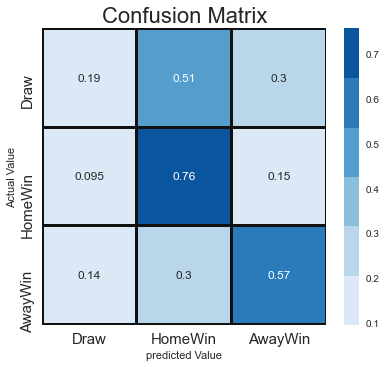

In [79]:
#evaluate the model on the train and test set
evaluate_model(output.best_estimator_,X_train_scaled,X_test_scaled,y_train,y_test)

After tuning the XGBoost model, it was over fitting on the training data but when tested on unseen data, the accuracy score increase to 56% with a probability of loss at -0.9

- #### KNN model using the gridsearchCV

In [80]:
#instantiate the pipeline with the steps
knn_model = Pipeline(steps=[('classifier', KNeighborsClassifier())])
knn_model

Pipeline(steps=[('classifier', KNeighborsClassifier())])

In [81]:
#set the n_neighbors
#set the metric to euclidean and minkowski
param = [{
    'classifier__leaf_size':[5,10,20,40,60],
    'classifier__n_neighbors': [3,5,10,20,50,],
    'classifier__weights':['uniform','distance'],
    'classifier__metric':['euclidean','minkowski','manhattan']}]

grid = GridSearchCV(estimator = knn_model,
                    param_grid = param,scoring='accuracy',cv=5)

In [82]:
#fit the grid on the training dataset
output = grid.fit(X_train_scaled, y_train)
#put the results in a dataframe
pd.DataFrame(output.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__leaf_size,param_classifier__metric,param_classifier__n_neighbors,param_classifier__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.012031,0.001341,0.200085,0.012867,5,euclidean,3,uniform,"{'classifier__leaf_size': 5, 'classifier__metr...",0.511743,0.512361,0.484230,0.486085,0.470006,0.492885,0.016610,141
1,0.011756,0.001006,0.128286,0.007841,5,euclidean,3,distance,"{'classifier__leaf_size': 5, 'classifier__metr...",0.519159,0.525340,0.485467,0.504638,0.483612,0.503643,0.016995,121
2,0.009580,0.000716,0.189011,0.017858,5,euclidean,5,uniform,"{'classifier__leaf_size': 5, 'classifier__metr...",0.516069,0.518541,0.504638,0.499691,0.498454,0.507479,0.008323,111
3,0.008014,0.000301,0.109743,0.003905,5,euclidean,5,distance,"{'classifier__leaf_size': 5, 'classifier__metr...",0.535229,0.534611,0.513296,0.520099,0.515770,0.523801,0.009338,91
4,0.008247,0.000582,0.197443,0.008845,5,euclidean,10,uniform,"{'classifier__leaf_size': 5, 'classifier__metr...",0.548826,0.552534,0.527520,0.539270,0.524428,0.538516,0.011160,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.004401,0.000197,0.096665,0.003148,60,manhattan,10,distance,"{'classifier__leaf_size': 60, 'classifier__met...",0.551298,0.536465,0.529375,0.542362,0.536797,0.539259,0.007296,71
146,0.004579,0.000286,0.147046,0.005251,60,manhattan,20,uniform,"{'classifier__leaf_size': 60, 'classifier__met...",0.558714,0.575402,0.548547,0.539889,0.541126,0.552735,0.013167,46
147,0.004400,0.000180,0.111873,0.002931,60,manhattan,20,distance,"{'classifier__leaf_size': 60, 'classifier__met...",0.567367,0.576638,0.546691,0.547928,0.536797,0.555084,0.014639,41
148,0.004322,0.000069,0.174090,0.004884,60,manhattan,50,uniform,"{'classifier__leaf_size': 60, 'classifier__met...",0.563659,0.567985,0.559678,0.554113,0.567718,0.562631,0.005232,26


In [83]:
#check the best parameter from the models
output.best_params_

{'classifier__leaf_size': 5,
 'classifier__metric': 'euclidean',
 'classifier__n_neighbors': 50,
 'classifier__weights': 'distance'}

In [84]:
#check the best score for the best parameter
output.best_score_

0.5709141820566861

Training Scores:
Accuracy Score: 1.0
----
Log loss Score: 2.1094237467877998e-15
----
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1983
           1       1.00      1.00      1.00      3671
           2       1.00      1.00      1.00      2433

    accuracy                           1.00      8087
   macro avg       1.00      1.00      1.00      8087
weighted avg       1.00      1.00      1.00      8087

------------
Test Scores:
Accuracy Score: 0.5736894164193868
----
Log loss Score: 0.9454030716928369
----
              precision    recall  f1-score   support

           0       0.40      0.12      0.18       508
           1       0.59      0.83      0.69       925
           2       0.57      0.56      0.57       589

    accuracy                           0.57      2022
   macro avg       0.52      0.50      0.48      2022
weighted avg       0.54      0.57      0.53      2022



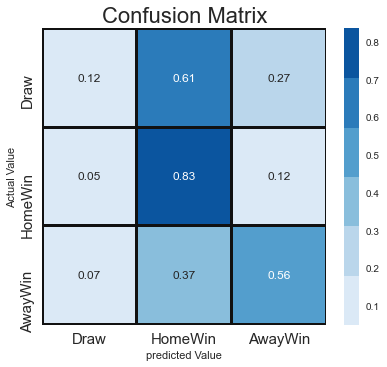

In [85]:
#evaluate the model on the train and test set
evaluate_model(output.best_estimator_,X_train_scaled,X_test_scaled,y_train,y_test)

KNN increase with 6% after hyper tuning it, the accuracy score on the test data is 57%, but was overfitting on the training data.

- #### Naive Bayes model using the gridsearchCV

In [86]:
#instantiate the pipeline with the steps
naive_bayes = Pipeline(steps=[('classifier', GaussianNB())])
naive_bayes

Pipeline(steps=[('classifier', GaussianNB())])

In [87]:
param = [{
    'classifier__var_smoothing':[2e-9,2e-10,2e-5,2e-20,1e-10,1e-9,2e-8,2e-1]}]

grid = GridSearchCV(estimator =naive_bayes,
                    param_grid = param, scoring='accuracy',cv=5)

In [88]:
#fit the grid on the training dataset
output = grid.fit(X_train_scaled, y_train)
#put the results in a dataframe
pd.DataFrame(output.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__var_smoothing,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002456,0.000195,0.000911,0.000035,2e-09,{'classifier__var_smoothing': 2e-09},0.544499,0.565513,0.539889,0.530612,0.552876,0.546678,0.011850,2
1,0.002169,0.000052,0.000849,0.000004,2e-10,{'classifier__var_smoothing': 2e-10},0.544499,0.565513,0.539889,0.530612,0.552876,0.546678,0.011850,2
2,0.002149,0.000019,0.000850,0.000002,2e-05,{'classifier__var_smoothing': 2e-05},0.544499,0.565513,0.539889,0.530612,0.552876,0.546678,0.011850,2
3,0.002135,0.000007,0.000850,0.000003,2e-20,{'classifier__var_smoothing': 2e-20},0.544499,0.565513,0.539889,0.530612,0.552876,0.546678,0.011850,2
4,0.002144,0.000012,0.000850,0.000004,1e-10,{'classifier__var_smoothing': 1e-10},0.544499,0.565513,0.539889,0.530612,0.552876,0.546678,0.011850,2
5,0.002150,0.000025,0.000856,0.000007,1e-09,{'classifier__var_smoothing': 1e-09},0.544499,0.565513,0.539889,0.530612,0.552876,0.546678,0.011850,2
6,0.002549,0.000450,0.000911,0.000063,2e-08,{'classifier__var_smoothing': 2e-08},0.544499,0.565513,0.539889,0.530612,0.552876,0.546678,0.011850,2
7,0.002167,0.000015,0.000854,0.000009,0.2,{'classifier__var_smoothing': 0.2},0.547590,0.568603,0.551639,0.532468,0.561534,0.552367,0.012385,1


In [89]:
#check the best parameter from the models
output.best_params_

{'classifier__var_smoothing': 0.2}

In [90]:
#check the best score for the best parameter
output.best_score_

0.5523665809733265

Training Scores:
Accuracy Score: 0.5545937925064919
----
Log loss Score: 0.9741169681064835
----
              precision    recall  f1-score   support

           0       0.33      0.23      0.27      1983
           1       0.62      0.73      0.67      3671
           2       0.56      0.55      0.56      2433

    accuracy                           0.55      8087
   macro avg       0.50      0.50      0.50      8087
weighted avg       0.53      0.55      0.54      8087

------------
Test Scores:
Accuracy Score: 0.5593471810089021
----
Log loss Score: 0.9696372001476627
----
              precision    recall  f1-score   support

           0       0.35      0.22      0.27       508
           1       0.63      0.74      0.68       925
           2       0.55      0.56      0.56       589

    accuracy                           0.56      2022
   macro avg       0.51      0.51      0.50      2022
weighted avg       0.53      0.56      0.54      2022



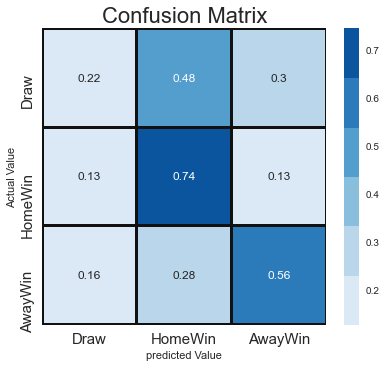

In [91]:
#evaluate the model on the train and test set
evaluate_model(output.best_estimator_,X_train_scaled,X_test_scaled,y_train,y_test)

Naive bayes model also increase with 1%, which bring the score to 56% after tuning it with a probability of loss still at -0.9 . 

- #### Support Vector Machine(SVC) model using the gridsearchCV

In [92]:
#instantiate the pipeline with the steps
svc= Pipeline(steps=[('classifier', SVC(decision_function_shape='ovo',probability=True))])
svc

Pipeline(steps=[('classifier',
                 SVC(decision_function_shape='ovo', probability=True))])

In [93]:
param = [{
    'classifier__C':[0.5,0.2,1.0,1.5,2.0,5.0],
    'classifier__gamma':['auto']}]

grid = GridSearchCV(estimator = svc,
                    param_grid = param, scoring='accuracy',cv=5)

In [94]:
#fit the grid on the training dataset
output = grid.fit(X_train_scaled, y_train)
#put the results in a dataframe
pd.DataFrame(output.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,7.169557,0.117319,0.162672,0.002301,0.5,auto,"{'classifier__C': 0.5, 'classifier__gamma': 'a...",0.577874,0.584672,0.567100,0.572047,0.588126,0.577964,0.007763,5
1,7.430465,0.158669,0.173909,0.020189,0.2,auto,"{'classifier__C': 0.2, 'classifier__gamma': 'a...",0.567367,0.577256,0.563389,0.565244,0.573902,0.569432,0.005282,6
2,7.179785,0.220693,0.162933,0.008533,1,auto,"{'classifier__C': 1.0, 'classifier__gamma': 'a...",0.579728,0.584672,0.575139,0.576376,0.586889,0.580561,0.004573,4
3,7.026377,0.143794,0.155799,0.002489,1.5,auto,"{'classifier__C': 1.5, 'classifier__gamma': 'a...",0.582818,0.588381,0.576994,0.578850,0.587508,0.582910,0.004529,1
4,6.960233,0.112684,0.158770,0.008852,2,auto,"{'classifier__C': 2.0, 'classifier__gamma': 'a...",0.584672,0.585909,0.575139,0.578231,0.586889,0.582168,0.004636,2
5,6.885112,0.112578,0.155846,0.002957,5,auto,"{'classifier__C': 5.0, 'classifier__gamma': 'a...",0.581582,0.585290,0.579468,0.576994,0.586271,0.581921,0.003484,3


In [95]:
#check the best parameter from the models
output.best_params_

{'classifier__C': 1.5, 'classifier__gamma': 'auto'}

In [96]:
#check the best score for the best parameter
output.best_score_

0.582910179466775

Training Scores:
Accuracy Score: 0.5845183628045011
----
Log loss Score: 0.9023352965199148
----
              precision    recall  f1-score   support

           0       0.48      0.02      0.04      1983
           1       0.58      0.87      0.70      3671
           2       0.60      0.61      0.61      2433

    accuracy                           0.58      8087
   macro avg       0.55      0.50      0.45      8087
weighted avg       0.56      0.58      0.51      8087

------------
Test Scores:
Accuracy Score: 0.5791295746785361
----
Log loss Score: 0.9143287301447667
----
              precision    recall  f1-score   support

           0       0.33      0.01      0.03       508
           1       0.59      0.88      0.70       925
           2       0.57      0.60      0.58       589

    accuracy                           0.58      2022
   macro avg       0.50      0.50      0.44      2022
weighted avg       0.52      0.58      0.50      2022



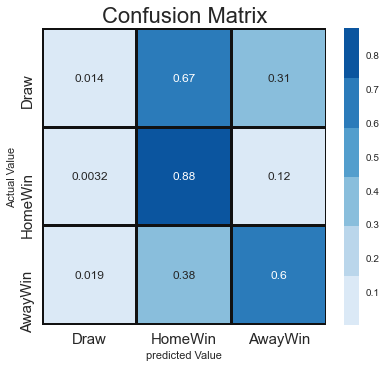

In [97]:
#evaluate the model on the train and test set
evaluate_model(output.best_estimator_,X_train_scaled,X_test_scaled,y_train,y_test)

The SVC model performed better on unseen data with an accuracy of 58% and a probability of loss at -0.9 . With the tuning we are able to achieve a 1% change in the score.

- #### CatBoost model using the gridsearchCV

In [162]:
#instantiate the pipeline with the steps
cat_boost = Pipeline(steps=[('classifier', CatBoostClassifier(loss_function='MultiClass',classes_count=3,silent=True))])
cat_boost

Pipeline(steps=[('classifier',
                 <catboost.core.CatBoostClassifier object at 0x7f93e56aa130>)])

In [163]:
#set the parameters
param = [{
    'classifier__depth':[10,20],
    'classifier__border_count':[100,128],
    'classifier__l2_leaf_reg': [5,8],
    'classifier__leaf_estimation_method':['Newton'],
    'classifier__eval_metric':['Accuracy'],
    'classifier__iterations':[800]}]


grid = GridSearchCV(estimator = cat_boost,
                    param_grid = param, scoring='accuracy',cv=5)

In [164]:
#fit the grid on the training dataset
output = grid.fit(X_train_scaled, y_train)
#put the results in a dataframe
pd.DataFrame(output.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__border_count,param_classifier__depth,param_classifier__eval_metric,param_classifier__iterations,param_classifier__l2_leaf_reg,param_classifier__leaf_estimation_method,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,23.982904,0.810015,0.010764,0.001502,100,10,Accuracy,800,5,Newton,"{'classifier__border_count': 100, 'classifier_...",0.593943,0.572311,0.571429,0.562771,0.567100,0.573511,0.010768,4
1,23.990549,0.702450,0.010841,0.001051,100,10,Accuracy,800,8,Newton,"{'classifier__border_count': 100, 'classifier_...",0.595797,0.576638,0.577613,0.568336,0.566481,0.576973,0.010388,2
2,0.024825,0.002803,0.000000,0.000000,100,20,Accuracy,800,5,Newton,"{'classifier__border_count': 100, 'classifier_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
3,0.021853,0.000610,0.000000,0.000000,100,20,Accuracy,800,8,Newton,"{'classifier__border_count': 100, 'classifier_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
4,29.747688,1.646853,0.011607,0.002324,128,10,Accuracy,800,5,Newton,"{'classifier__border_count': 128, 'classifier_...",0.588999,0.579728,0.568955,0.569573,0.570192,0.575489,0.007826,3
5,28.508438,0.735059,0.010304,0.000422,128,10,Accuracy,800,8,Newton,"{'classifier__border_count': 128, 'classifier_...",0.593325,0.579110,0.573284,0.568336,0.573284,0.577468,0.008632,1
6,0.023046,0.001074,0.000000,0.000000,128,20,Accuracy,800,5,Newton,"{'classifier__border_count': 128, 'classifier_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
7,0.023242,0.000708,0.000000,0.000000,128,20,Accuracy,800,8,Newton,"{'classifier__border_count': 128, 'classifier_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,8


In [165]:
#check the best parameter from the models
output.best_params_

{'classifier__border_count': 128,
 'classifier__depth': 10,
 'classifier__eval_metric': 'Accuracy',
 'classifier__iterations': 800,
 'classifier__l2_leaf_reg': 8,
 'classifier__leaf_estimation_method': 'Newton'}

In [166]:
#check the best score for the best parameter
output.best_score_

0.5774678497087115

Training Scores:
Accuracy Score: 0.8278718931618647
----
Log loss Score: 0.5641720032720575
----
              precision    recall  f1-score   support

           0       0.93      0.62      0.75      1983
           1       0.79      0.94      0.86      3671
           2       0.83      0.83      0.83      2433

    accuracy                           0.83      8087
   macro avg       0.85      0.80      0.81      8087
weighted avg       0.84      0.83      0.82      8087

------------
Test Scores:
Accuracy Score: 0.5707220573689417
----
Log loss Score: 0.9197772037879917
----
              precision    recall  f1-score   support

           0       0.38      0.17      0.24       508
           1       0.62      0.78      0.69       925
           2       0.55      0.58      0.56       589

    accuracy                           0.57      2022
   macro avg       0.52      0.51      0.50      2022
weighted avg       0.54      0.57      0.54      2022



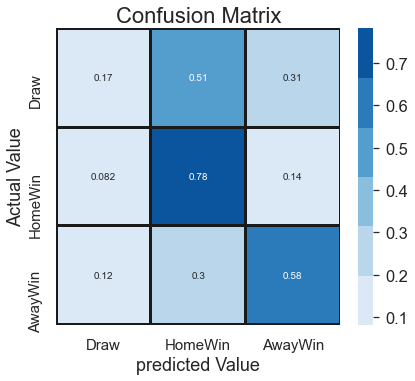

In [167]:
#evaluate the model on the train and test set
evaluate_model(output.best_estimator_,X_train_scaled,X_test_scaled,y_train,y_test)

The Catboost model was very fast at predicting the model with a score of 57% on the test data, which is still the same as most of the other models.

### Testing the Final model on the holdout dataset-(Unseen Data)


I will be testing the final model on the validation set to see how the model will perform on unseen data.

In [114]:
final_model = LogisticRegression(multi_class="multinomial",C = 5.0,penalty='l2',solver='lbfgs',max_iter=100)
model_lg =final_model.fit(X_train_scaled,y_train)
model_lg

LogisticRegression(C=5.0, multi_class='multinomial')

In [125]:
y_hat_val = final_model.predict(X_val_scaled)
y_hat_train = final_model.predict(X_train_scaled)

In [126]:
residuals = np.abs(y_train - y_hat_train)
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))

0    4743
1    2659
2     685
Name: target, dtype: int64
0    0.586497
1    0.328799
2    0.084704
Name: target, dtype: float64


In [127]:
residuals = np.abs(y_val - y_hat_val)
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))

0    1072
1     558
2     155
Name: target, dtype: int64
0    0.600560
1    0.312605
2    0.086835
Name: target, dtype: float64


In [128]:
val_prob = final_model.predict_proba(X_val_scaled)

Accuracy Score: 0.6005602240896358
----
Log loss Score: 0.8761020082024816
----
              precision    recall  f1-score   support

           0       0.46      0.05      0.10       421
           1       0.62      0.84      0.71       825
           2       0.58      0.65      0.61       539

    accuracy                           0.60      1785
   macro avg       0.55      0.52      0.48      1785
weighted avg       0.57      0.60      0.54      1785



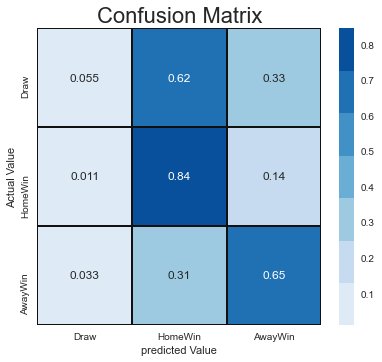

In [129]:
print(f"Accuracy Score: {accuracy_score(y_val,y_hat_val)}")
print("----")
print(f"Log loss Score: {log_loss(y_val, val_prob)}")
print("----")
print(classification_report(y_val,y_hat_val))


plt.figure(figsize=(14,12))
plt.subplot(221)
ax=sns.heatmap(confusion_matrix(y_val,y_hat_val,normalize='true'),
               annot=True,linecolor='k',linewidth=1,
               cmap =sns.color_palette('Blues',7))
ax.xaxis.set_ticklabels(['Draw','HomeWin','AwayWin'])
ax.yaxis.set_ticklabels(['Draw','HomeWin','AwayWin'])
plt.title("Confusion Matrix",fontsize=22)
plt.xlabel("predicted Value")
plt.ylabel("Actual Value")
plt.show()

# Feature importances of the final model

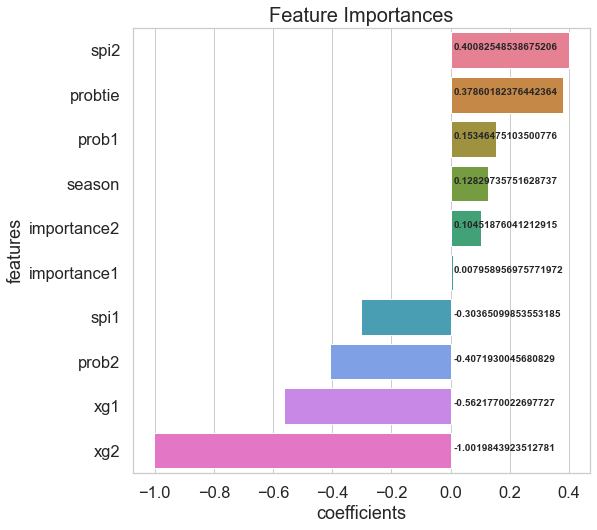

In [225]:
features_df = pd.DataFrame(final_model.coef_[0], X_train.columns).reset_index()
features_df = features_df.rename(columns={"index":"features", 0:"coefficients"})
features_df = features_df.sort_values(by="coefficients", ascending=False)

# plot conf_matrix, roc/auc, and feat importances
plt.figure(figsize=(18,18))
plt.subplot(223)
ax = sns.barplot(x = "coefficients", y = "features", data = features_df, palette = "husl")
plt.title("Feature Importances", fontsize=20)
for i, j in enumerate(features_df["coefficients"]):
    ax.text(.011, i, j, weight = "bold")

The top five most important features that the model predict is the soccer power index for the away team(spi2), and the probabilities that the game will be a homewin(prob1), probabilities of a draw(probtie), season of the match and how importance the match is the match . When using the model for predicting, the top five features are recommended in other to win the bet.

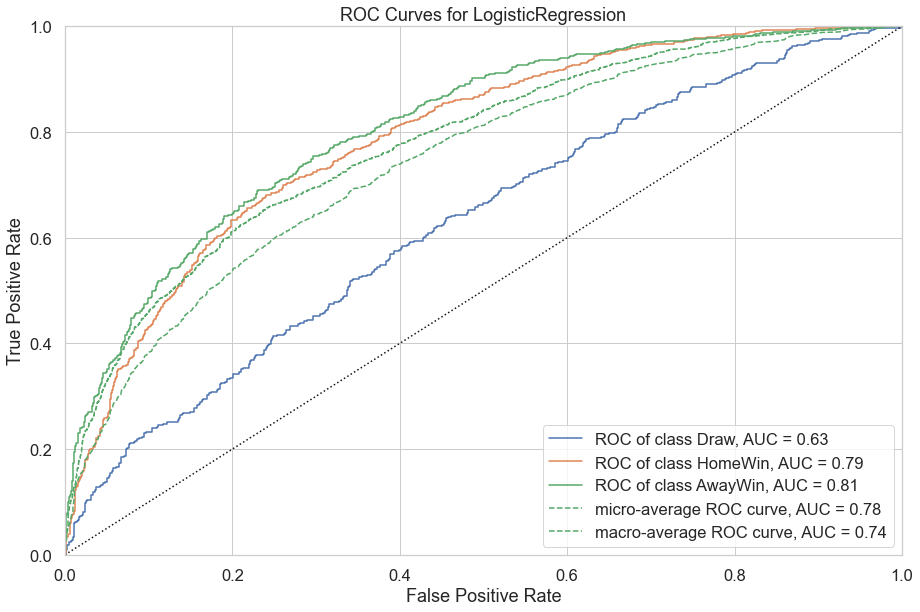

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [203]:
#plot the ROC-AUC plot for train and validation set
"""source: Yellowbrick python API- plot ROCAUC curve"""
roc_auc_curve = ROCAUC(final_model,classes = ['Draw','HomeWin','AwayWin'],size =(1080,700))
roc_auc_curve.fit(X_train_scaled,y_train)
roc_auc_curve.score(X_val_scaled,y_val)
roc_auc_curve.show()

In [226]:
#pickle final model 
deploy_model = pickle.dump(final_model,open('model.sav','wb'))

In [227]:
deploy_model = pickle.load(open('model.sav','rb'))
deploy_model

LogisticRegression(C=5.0, multi_class='multinomial')

## Summary of all models

- There was a monotonic trend performance with the accuracy score of all the models. As one increases the other decreases, which is due to the complexity of soccer games. After tuning several models, the Logistic Regression model was the best performing model in classifying the business problem. The model achieved an accuracy score of 60% on unseen data, weighted average score at 54% with a probability of loss at -0.9. The macro-average area under the curve is 0.74 and the micro average area under the curve is 0.78.

## Final Evaluation

- Even though soccer game is convoluted, I am confident that the model will be able to predict a match fixture either home and away with a 60% accuracy. The model was trained using the data from the last five season and I evaluated it's performance in predicting match results for the current season. The model did great predicting 80% average accuracy on the match fixture between . Soccer Analyst and soccer fans can make use of the model to minimize risk and also yield a high return on the bets. 

## Limitation

- There is a limitation to the model, due to developing the model using seven leagues which are; Barclays Premier League, UEFA Champions League,Major League Soccer, Italy Serie A , Spanish Primera Division, German Bundesliga, and French Ligue 1. Therefore, the performance of the model was not evaluated for other football leagues. Also, not all the teams are included in the training of the model due to their factors.

## Conclusions

- My recommendation will be to take into consideration each team's soccer power index before using the model to predict the match. To make it simple, using the model to predict a match before betting will give you more relevant information about each team's quality and more valuable insights to their performance analysis than studying the results afterwards.

- The stakeholder can use the model to predict upcoming match fixtures, but will advise to backup bets, if the model predicts a win class, back it up with a draw class because soccer is a tricky sport to model due to few goals scored in each match.


## Next Steps

- **Deep Learning Approach:** I have only used the supervised learning approach in the process of developing the machine learning model. In the future, I would like to incorporate unsupervised learning techniques like deep learning to improve the accuracy of the model. 

- **Team players performance:** I would like to include the soccer players, their physical performance and capabilities in the future analysis that will help improve the accuracy of the model.

- **Fifa World Cup soccer:** Since I only base my study on seven leagues. In the future, I would like to add more leagues and continue to update the model using the world cup data.
